# Predicting Default Payments with Fully-Connected NNs

Cristian Piacente 866020 \
Advanced Machine Learning course \
Master's degree in Computer Science @ University of Milan - Bicocca \
A.Y. 2024-25

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.optimizers import Adam

## Inspecting the data

### Load the data

In [205]:
# Load the training data
train_data = pd.read_csv('train.csv')

train_data

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0      19193     200000    2          1         1   38     -2     -2     -2   
1       1131     230000    2          2         1   34      0      0      0   
2      17557      50000    2          2         2   42      0      0      0   
3      29901      20000    1          2         2   29      0      0     -2   
4      14696      30000    2          3         1   59      1      2      2   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
25495  22487     480000    2          3         1   41      0      0      0   
25496   7121     200000    2          1         2   26      0     -1     -1   
25497   1412     450000    1          3         1   58     -1     -1     -1   
25498  29589     230000    1          2         1   35      0      0      0   
25499  28755      70000    2          2         2   34     -1     -1     -1   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0         -2  ...       2571       2571       2571      2772      2571   
1          0  ...     155335     153427     150514      8913      5449   
2          0  ...      49311      24663      24854      1763      2112   
3         -2  ...          0          0          0         0         0   
4          2  ...      30467      29858      28898      1950       200   
...      ...  ...        ...        ...        ...       ...       ...   
25495      0  ...     110289     100520      37080     35176     45000   
25496     -1  ...        253          0          0       599         0   
25497     -1  ...       9856        819        863      6271      5740   
25498      0  ...     170563     173697     179697      6000     10281   
25499     -1  ...      11019      11632       7864      1245         0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0          2571      2571      2571      2571                           0  
1          5339      5370      4435      4432                           1  
2          1756       324       336       351                           0  
3             0         0         0         0                           1  
4          2492         0       580         0                           1  
...         ...       ...       ...       ...                         ...  
25495     12022     14000     14000     10000                           0  
25496       253         0         0         0                           0  
25497      9905       823       867      2488                           0  
25498      8866      6000      6000      6000                           0  
25499     12019      1000       157      7851                           0  

[25500 rows x 25 columns]

In [206]:
# Drop the ID column as it is not relevant
train_data.drop(columns=['ID'], inplace=True)

In [5]:
train_data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

Here is a short description about each feature, to understand the data we have.

- **LIMIT_BAL**: Amount of given credit (in local currency), which includes both individual credit and family (supplementary) credit.
- **SEX**: Gender (1 = male; 2 = female).
- **EDUCATION**: Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others).
- **MARRIAGE**: Marital status (1 = married, 2 = single, 3 = others).
- **AGE**: Age of the client in years.
- Payment Status Features (April 2005 to September 2005)
    - **PAY_0**: Repayment status in September 2005 (-1 = paid on time, 1 = payment delay for one month, 2 = payment delay for two months, ..., 9 = payment delay for nine months and above).
    - **PAY_2**: Repayment status in August 2005 (scale same as above).
    - **PAY_3**: Repayment status in July 2005 (scale same as above).
    - **PAY_4**: Repayment status in June 2005 (scale same as above).
    - **PAY_5**: Repayment status in May 2005 (scale same as above).
    - **PAY_6**: Repayment status in April 2005 (scale same as above).
- Bill Statement Features (April 2005 to September 2005)
    - **BILL_AMT1**: Amount of bill statement in September 2005.
    - **BILL_AMT2**: Amount of bill statement in August 2005.
    - **BILL_AMT3**: Amount of bill statement in July 2005.
    - **BILL_AMT4**: Amount of bill statement in June 2005.
    - **BILL_AMT5**: Amount of bill statement in May 2005.
    - **BILL_AMT6**: Amount of bill statement in April 2005.
- Payment Amount Features (April 2005 to September 2005)
    - **PAY_AMT1**: Amount of previous payment in September 2005.
    - **PAY_AMT2**: Amount of previous payment in August 2005.
    - **PAY_AMT3**: Amount of previous payment in July 2005.
    - **PAY_AMT4**: Amount of previous payment in June 2005.
    - **PAY_AMT5**: Amount of previous payment in May 2005.
    - **PAY_AMT6**: Amount of previous payment in April 2005.

The Target variable is **default payment next month**, which is the default payment indicator for the next month (1 = yes, 0 = no).

Let's see if we can spot some inconsistencies from a very fast initial analysis.

In [7]:
# Initial dataset exploration, to see if we can spot some inconsistent values already
train_data.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    25500.000000  25500.000000  25500.000000  25500.000000  25500.000000   
mean    167569.007059      1.604118      1.852353      1.550392     35.509294   
std     130002.156470      0.489049      0.787991      0.522757      9.200408   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  25500.000000  25500.000000  25500.000000  25500.000000  25500.000000   
mean      -0.013098     -0.130784     -0.163294     -0.218235     -0.260706   
std        1.126314      1.199481      1.199697      1.169681      1.135663   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   25500.000000   25500.000000   25500.000000   25500.000000   
mean   ...   43336.952196   40307.121059   38924.328157    5594.010863   
std    ...   64433.082446   60870.691089   59659.509920   16235.253410   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2338.750000    1767.250000    1266.750000    1000.000000   
50%    ...   19111.000000   18112.500000   17150.000000    2100.000000   
75%    ...   54475.000000   50178.250000   49132.500000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2       PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  2.550000e+04   25500.000000   25500.000000   25500.000000   
mean   5.934389e+03    5319.529647    4812.161373    4812.480431   
std    2.381277e+04   18157.653215   15560.524538   15206.108094   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    8.270000e+02     396.000000     291.000000     251.000000   
50%    2.002000e+03    1800.000000    1500.000000    1500.000000   
75%    5.000000e+03    4560.500000    4000.000000    4071.500000   
max    1.684259e+06  896040.000000  621000.000000  426529.000000   

            PAY_AMT6  default payment next month  
count   25500.000000                25500.000000  
mean     5236.509176                    0.222941  
std     17958.888070                    0.416227  
min         0.000000                    0.000000  
25%       125.750000                    0.000000  
50%      1500.000000                    0.000000  
75%      4000.000000                    0.000000  
max    528666.000000                    1.000000  

[8 rows x 24 columns]

From this, we can see there are some inconsistent values for sure, e.g. EDUCATION > 4.

It means we'll need to perform Data Cleaning, but first let's spot all the issues and check what actions are needed.

### Data Cleaning Checks

#### Inconsistent Values

In [207]:
def get_inconsistency_df(df):
    # Define the conditions for inconsistencies
    conditions = {
        'LIMIT_BAL': df['LIMIT_BAL'] <= 0,
        'SEX': ~df['SEX'].isin([1, 2]),
        'EDUCATION': ~df['EDUCATION'].isin([1, 2, 3, 4]),
        'MARRIAGE': ~df['MARRIAGE'].isin([1, 2, 3]),
        'AGE': (df['AGE'] < 18) | (df['AGE'] > 100),
        'PAY_0': (df['PAY_0'] < -1) | (df['PAY_0'] > 9),
        'PAY_2': (df['PAY_2'] < -1) | (df['PAY_2'] > 9),
        'PAY_3': (df['PAY_3'] < -1) | (df['PAY_3'] > 9),
        'PAY_4': (df['PAY_4'] < -1) | (df['PAY_4'] > 9),
        'PAY_5': (df['PAY_5'] < -1) | (df['PAY_5'] > 9),
        'PAY_6': (df['PAY_6'] < -1) | (df['PAY_6'] > 9),
        'BILL_AMT1': df['BILL_AMT1'] < 0,
        'BILL_AMT2': df['BILL_AMT2'] < 0,
        'BILL_AMT3': df['BILL_AMT3'] < 0,
        'BILL_AMT4': df['BILL_AMT4'] < 0,
        'BILL_AMT5': df['BILL_AMT5'] < 0,
        'BILL_AMT6': df['BILL_AMT6'] < 0,
        'PAY_AMT1': df['PAY_AMT1'] < 0,
        'PAY_AMT2': df['PAY_AMT2'] < 0,
        'PAY_AMT3': df['PAY_AMT3'] < 0,
        'PAY_AMT4': df['PAY_AMT4'] < 0,
        'PAY_AMT5': df['PAY_AMT5'] < 0,
        'PAY_AMT6': df['PAY_AMT6'] < 0,
    }

    # Calculate the number of inconsistencies for each feature
    inconsistency_counts = {feature: condition.sum() for feature, condition in conditions.items()}

    # Create a DataFrame from the inconsistency counts
    inconsistency_summary_df = pd.DataFrame.from_dict(inconsistency_counts, orient='index', columns=['Number of Inconsistencies'])
    inconsistency_summary_df.index.name = 'Feature'

    return inconsistency_summary_df


get_inconsistency_df(train_data)

Number of Inconsistencies
Feature                             
LIMIT_BAL                          0
SEX                                0
EDUCATION                        286
MARRIAGE                          49
AGE                                0
PAY_0                           2313
PAY_2                           3199
PAY_3                           3454
PAY_4                           3659
PAY_5                           3825
PAY_6                           4145
BILL_AMT1                        502
BILL_AMT2                        556
BILL_AMT3                        546
BILL_AMT4                        548
BILL_AMT5                        545
BILL_AMT6                        573
PAY_AMT1                           0
PAY_AMT2                           0
PAY_AMT3                           0
PAY_AMT4                           0
PAY_AMT5                           0
PAY_AMT6                           0

To ensure data consistency, conditions include positive LIMIT_BAL, valid categorical values for SEX, EDUCATION, MARRIAGE, and AGE between 18 and 100. 

The PAY features must be in the range -1 to 9, while all BILL_AMT and PAY_AMT features should be non-negative.

#### Missing Values

In [9]:
# Check for missing values
train_data.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

No action needed here: there are no missing values at all.

#### Duplicate Rows

In [10]:
# Check for duplicate rows (after removing the ID column)
train_data[train_data.duplicated()]

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
7647      150000    2          1         1   31      1     -2     -2     -2   
8123      140000    1          1         2   29      1     -2     -2     -2   
8532      150000    2          1         1   38      1     -2     -2     -2   
12738      80000    2          2         2   25     -2     -2     -2     -2   
13332      80000    2          3         1   42     -2     -2     -2     -2   
13770     200000    1          1         2   30     -2     -2     -2     -2   
13953     500000    1          1         1   43      1     -2     -2     -2   
14030     200000    2          1         1   34      1     -2     -2     -2   
14462     200000    2          1         1   36      1     -2     -2     -2   
14544     210000    1          2         1   39     -1     -1     -1     -1   
15165      50000    1          2         2   26      1     -2     -2     -2   
15810     230000    1          1         1   39     -1     -1     -1     -1   
15880      90000    2          1         2   31      1     -2     -2     -2   
17749     150000    2          1         2   28      1     -2     -2     -2   
17901     360000    2          1         1   41     -2     -2     -2     -2   
18724     360000    1          1         2   29      1     -2     -2     -2   
19728     200000    2          2         2   26     -2     -2     -2     -2   
19761     110000    2          1         2   31      1     -2     -2     -2   
20105     180000    2          1         2   28      1     -2     -2     -2   
21694     210000    2          1         2   39      1     -2     -2     -2   
22379     360000    2          1         2   29      1     -2     -2     -2   
23078     220000    1          1         1   42      1     -2     -2     -2   
23235     360000    1          1         2   32     -2     -2     -2     -2   
23619     210000    2          2         1   49      1     -2     -2     -2   
24338     360000    1          2         1   41      1     -2     -2     -2   

       PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
7647      -2  ...          0          0          0         0         0   
8123      -2  ...          0          0          0         0         0   
8532      -2  ...          0          0          0         0         0   
12738     -2  ...          0          0          0         0         0   
13332     -2  ...          0          0          0         0         0   
13770     -2  ...          0          0          0         0         0   
13953     -2  ...          0          0          0         0         0   
14030     -2  ...          0          0          0         0         0   
14462     -2  ...          0          0          0         0         0   
14544     -1  ...       1443       1443       1443      1443      1443   
15165     -2  ...          0          0          0         0         0   
15810     -1  ...        660        660        660       660       660   
15880     -2  ...          0          0          0         0         0   
17749     -2  ...          0          0          0         0         0   
17901     -2  ...          0          0          0         0         0   
18724     -2  ...          0          0          0         0         0   
19728     -2  ...          0          0          0         0         0   
19761     -2  ...          0          0          0         0         0   
20105     -2  ...          0          0          0         0         0   
21694     -2  ...          0          0          0         0         0   
22379     -2  ...          0          0          0         0         0   
23078     -2  ...          0          0          0         0         0   
23235     -2  ...          0          0          0         0         0   
23619     -2  ...          0          0          0         0         0   
24338     -2  ...          0          0          0         0         0   

       PAY_AMT3  PAY_AMT4  

These rows don't add any information, we'll remove them before passing the data to the Neural Networks.

### EDA

To analyze the distribution of the features (also to confirm some inconsistencies shown before) and to find the relationships among them and also the target variable, we'll perform some EDA.

#### Univariate Analysis

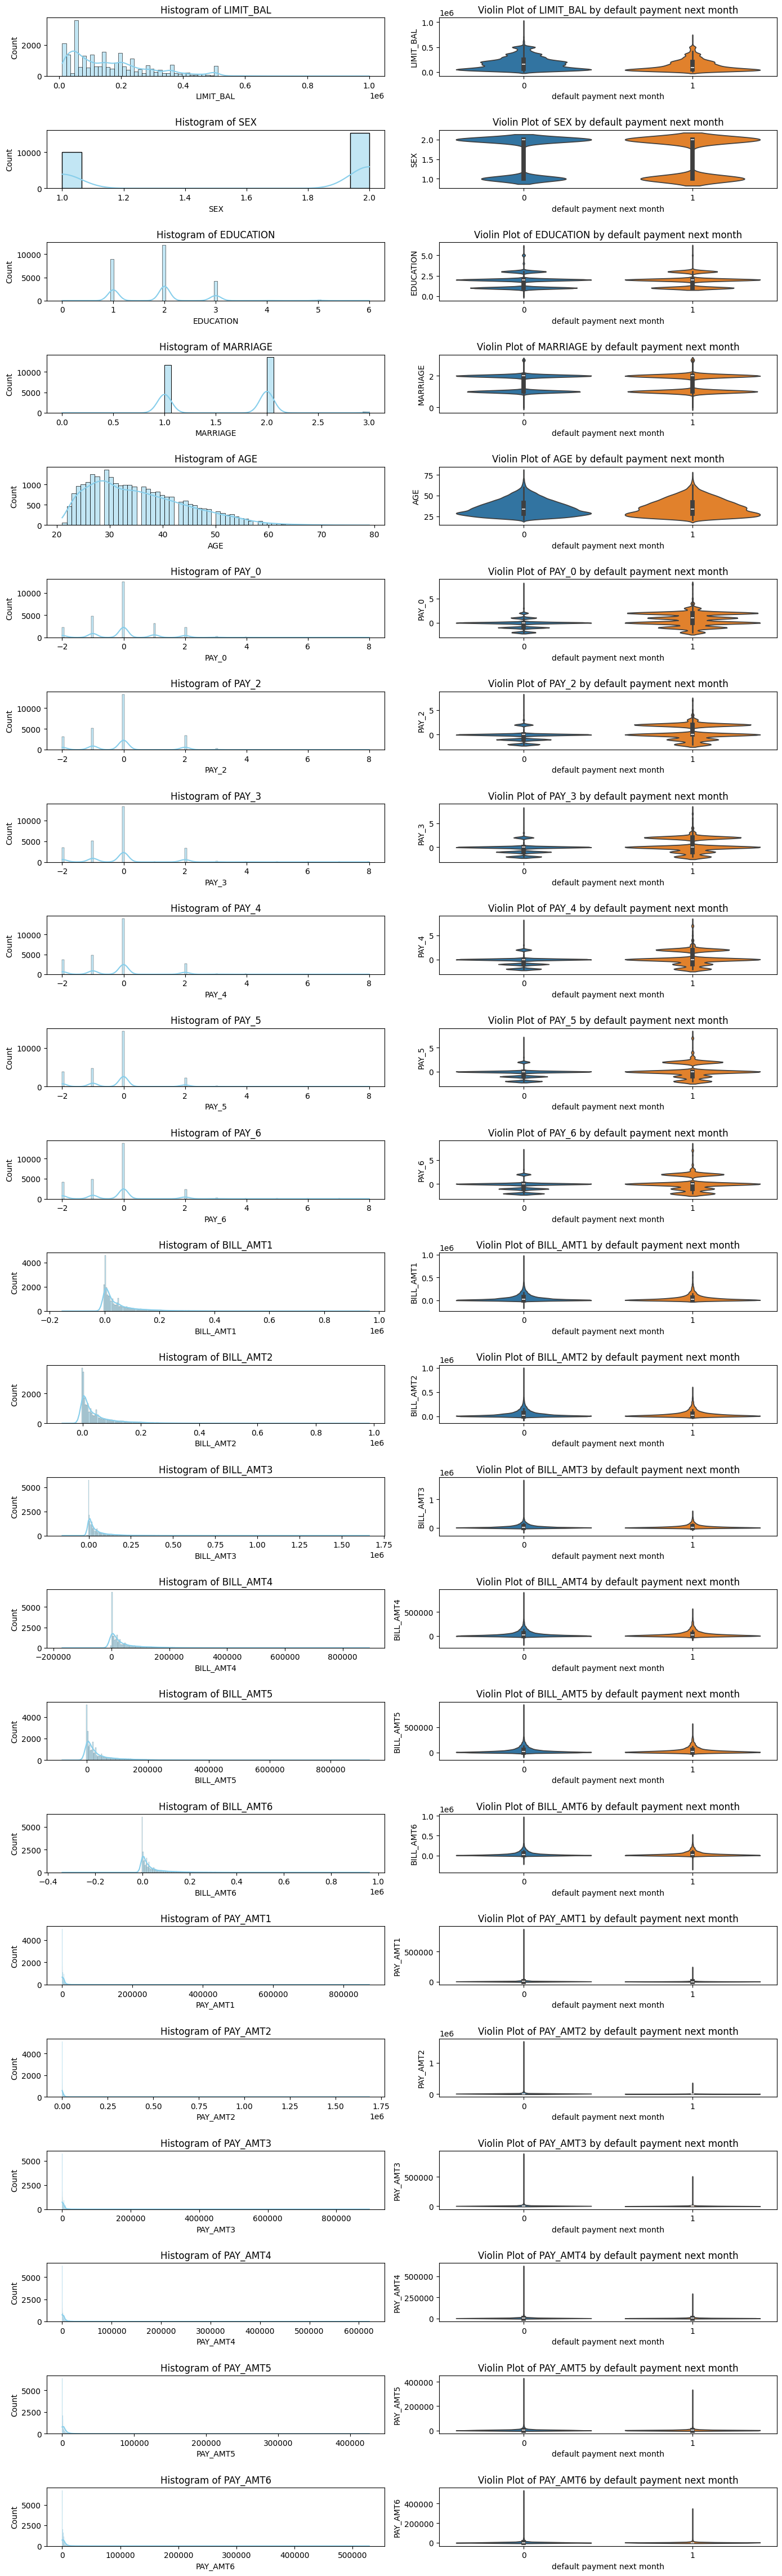

In [11]:
# Define the target and features
target_col = 'default payment next month'
features = [col for col in train_data.columns if col != target_col]

# Set up the plotting area with only two columns for histograms and violin plots
fig, axes = plt.subplots(len(features), 2, figsize=(14, len(features) * 2))

# Loop through each feature and create the required plots
for i, feature in enumerate(features):
    # Histogram
    sns.histplot(train_data[feature], kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {feature}")
    axes[i, 0].set_xlabel(feature)

    # Violin plot colored by target variable
    sns.violinplot(data=train_data, x=target_col, y=feature, hue=target_col, ax=axes[i, 1])
    axes[i, 1].set_title(f"Violin Plot of {feature} by {target_col}")
    axes[i, 1].get_legend().remove()

plt.tight_layout()
plt.show()

We can see the distributions are skewed: during Data Cleaning, we'll perform log scaling to reduce long tails.

Also, we will drop SEX, EDUCATION, MARRIAGE, AGE since they don't add significant value to predicting the target.

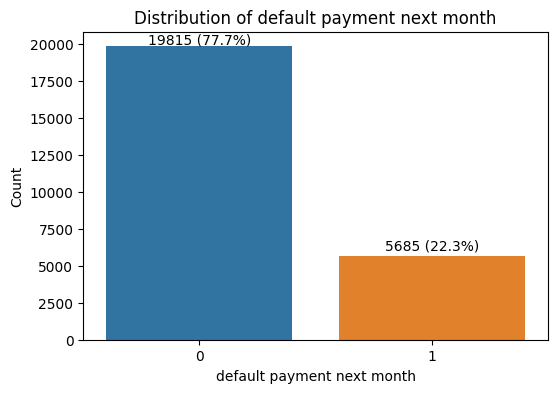

In [12]:
# Distribution of the target
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=train_data, x=target_col, hue=target_col, legend=False)

# Add labels with count and percentage
total = len(train_data)
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    if percentage > 0:
        ax.annotate(f'{count} ({percentage:.1f}%)', (p.get_x() + p.get_width() / 2., p.get_height() * 0.985), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Set titles and labels
plt.title(f"Distribution of {target_col}")
plt.xlabel(target_col)
plt.ylabel("Count")
plt.show()

The target is not balanced: we'll need to focus on the prediction of the positive class.

We'll focus on **recall** to find the most positives among all the real positives.

#### Covariate Analysis

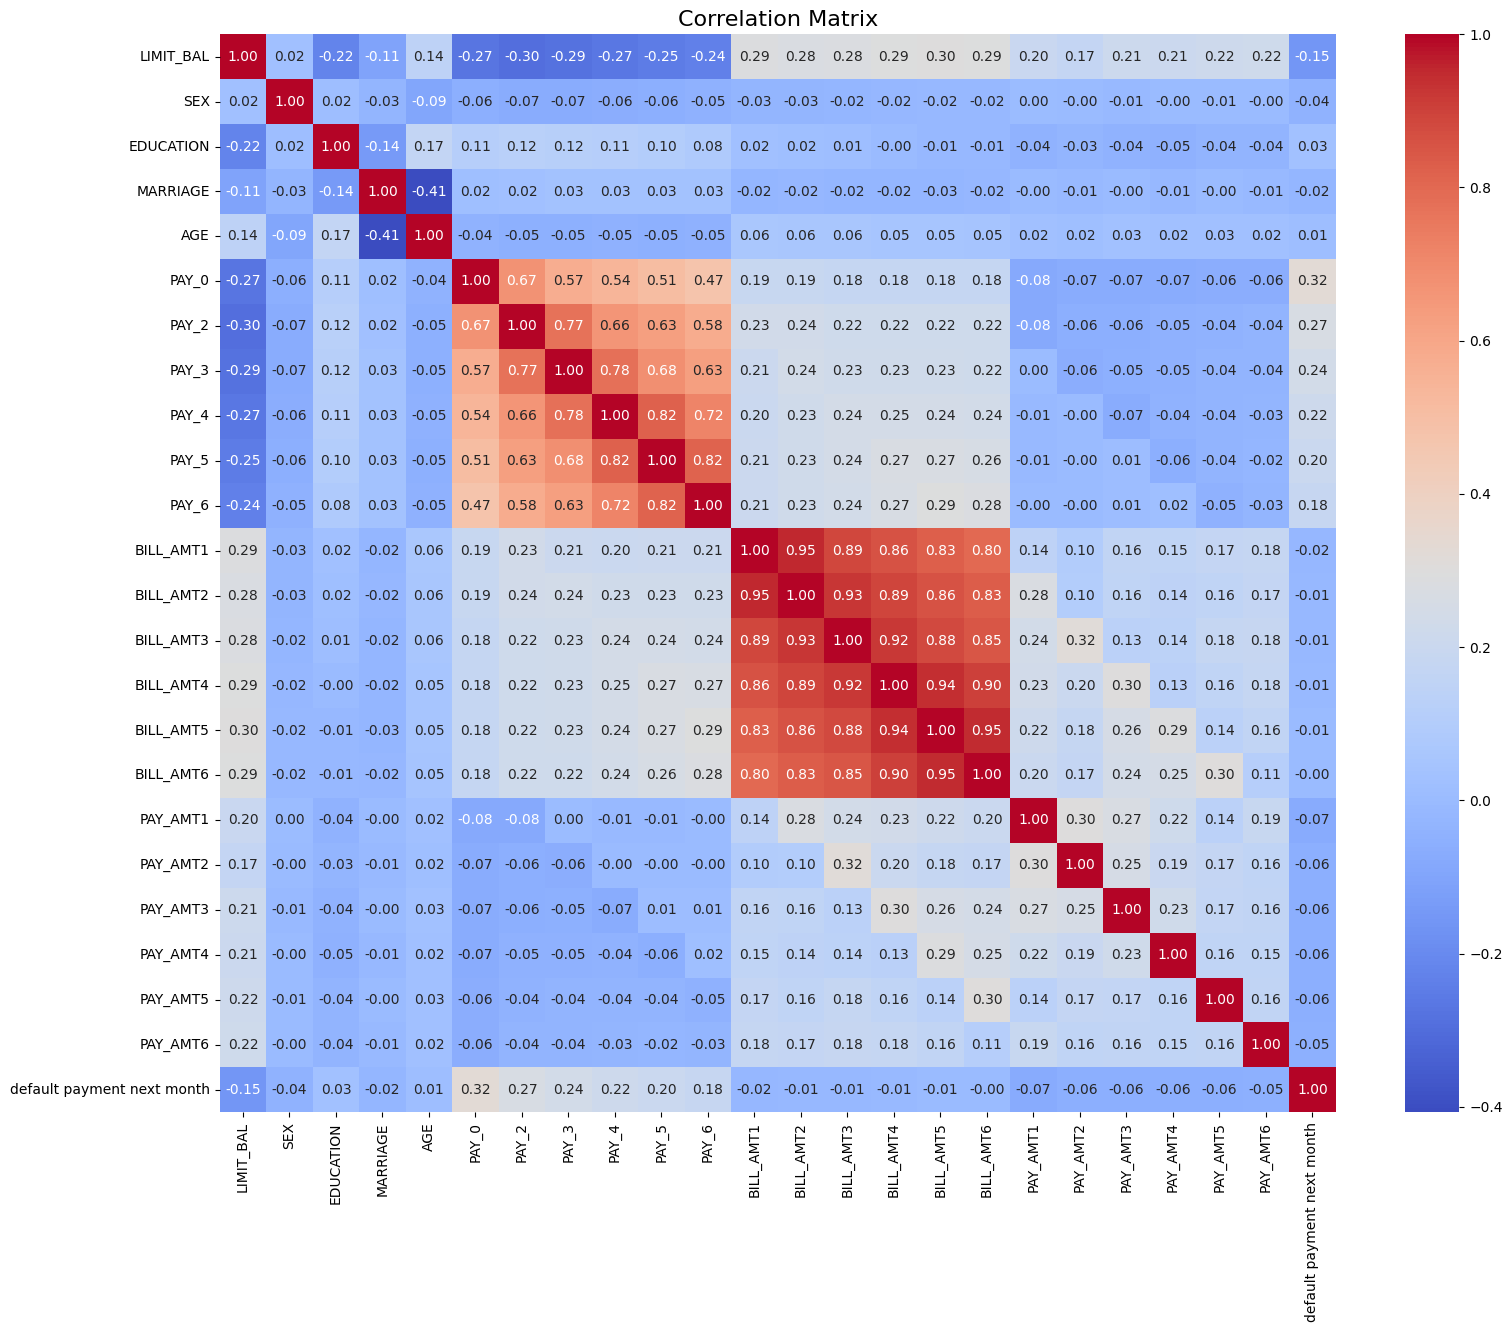

In [25]:
# Correlation Matrix
plt.figure(figsize=(18, 14))
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=16)
plt.show()

From the correlation matrix we can see PAY_0 is the most correlated feature with the target. 

Before creating a Neural Network, we will create a baseline model (without using Machine Learning, to have initial metrics) which uses PAY_0 for sure to see how it performs in both training and test.

Other PAY and BILL_AMT features show moderate correlations with each other, but these aren't strong enough to justify specific feature engineering steps.

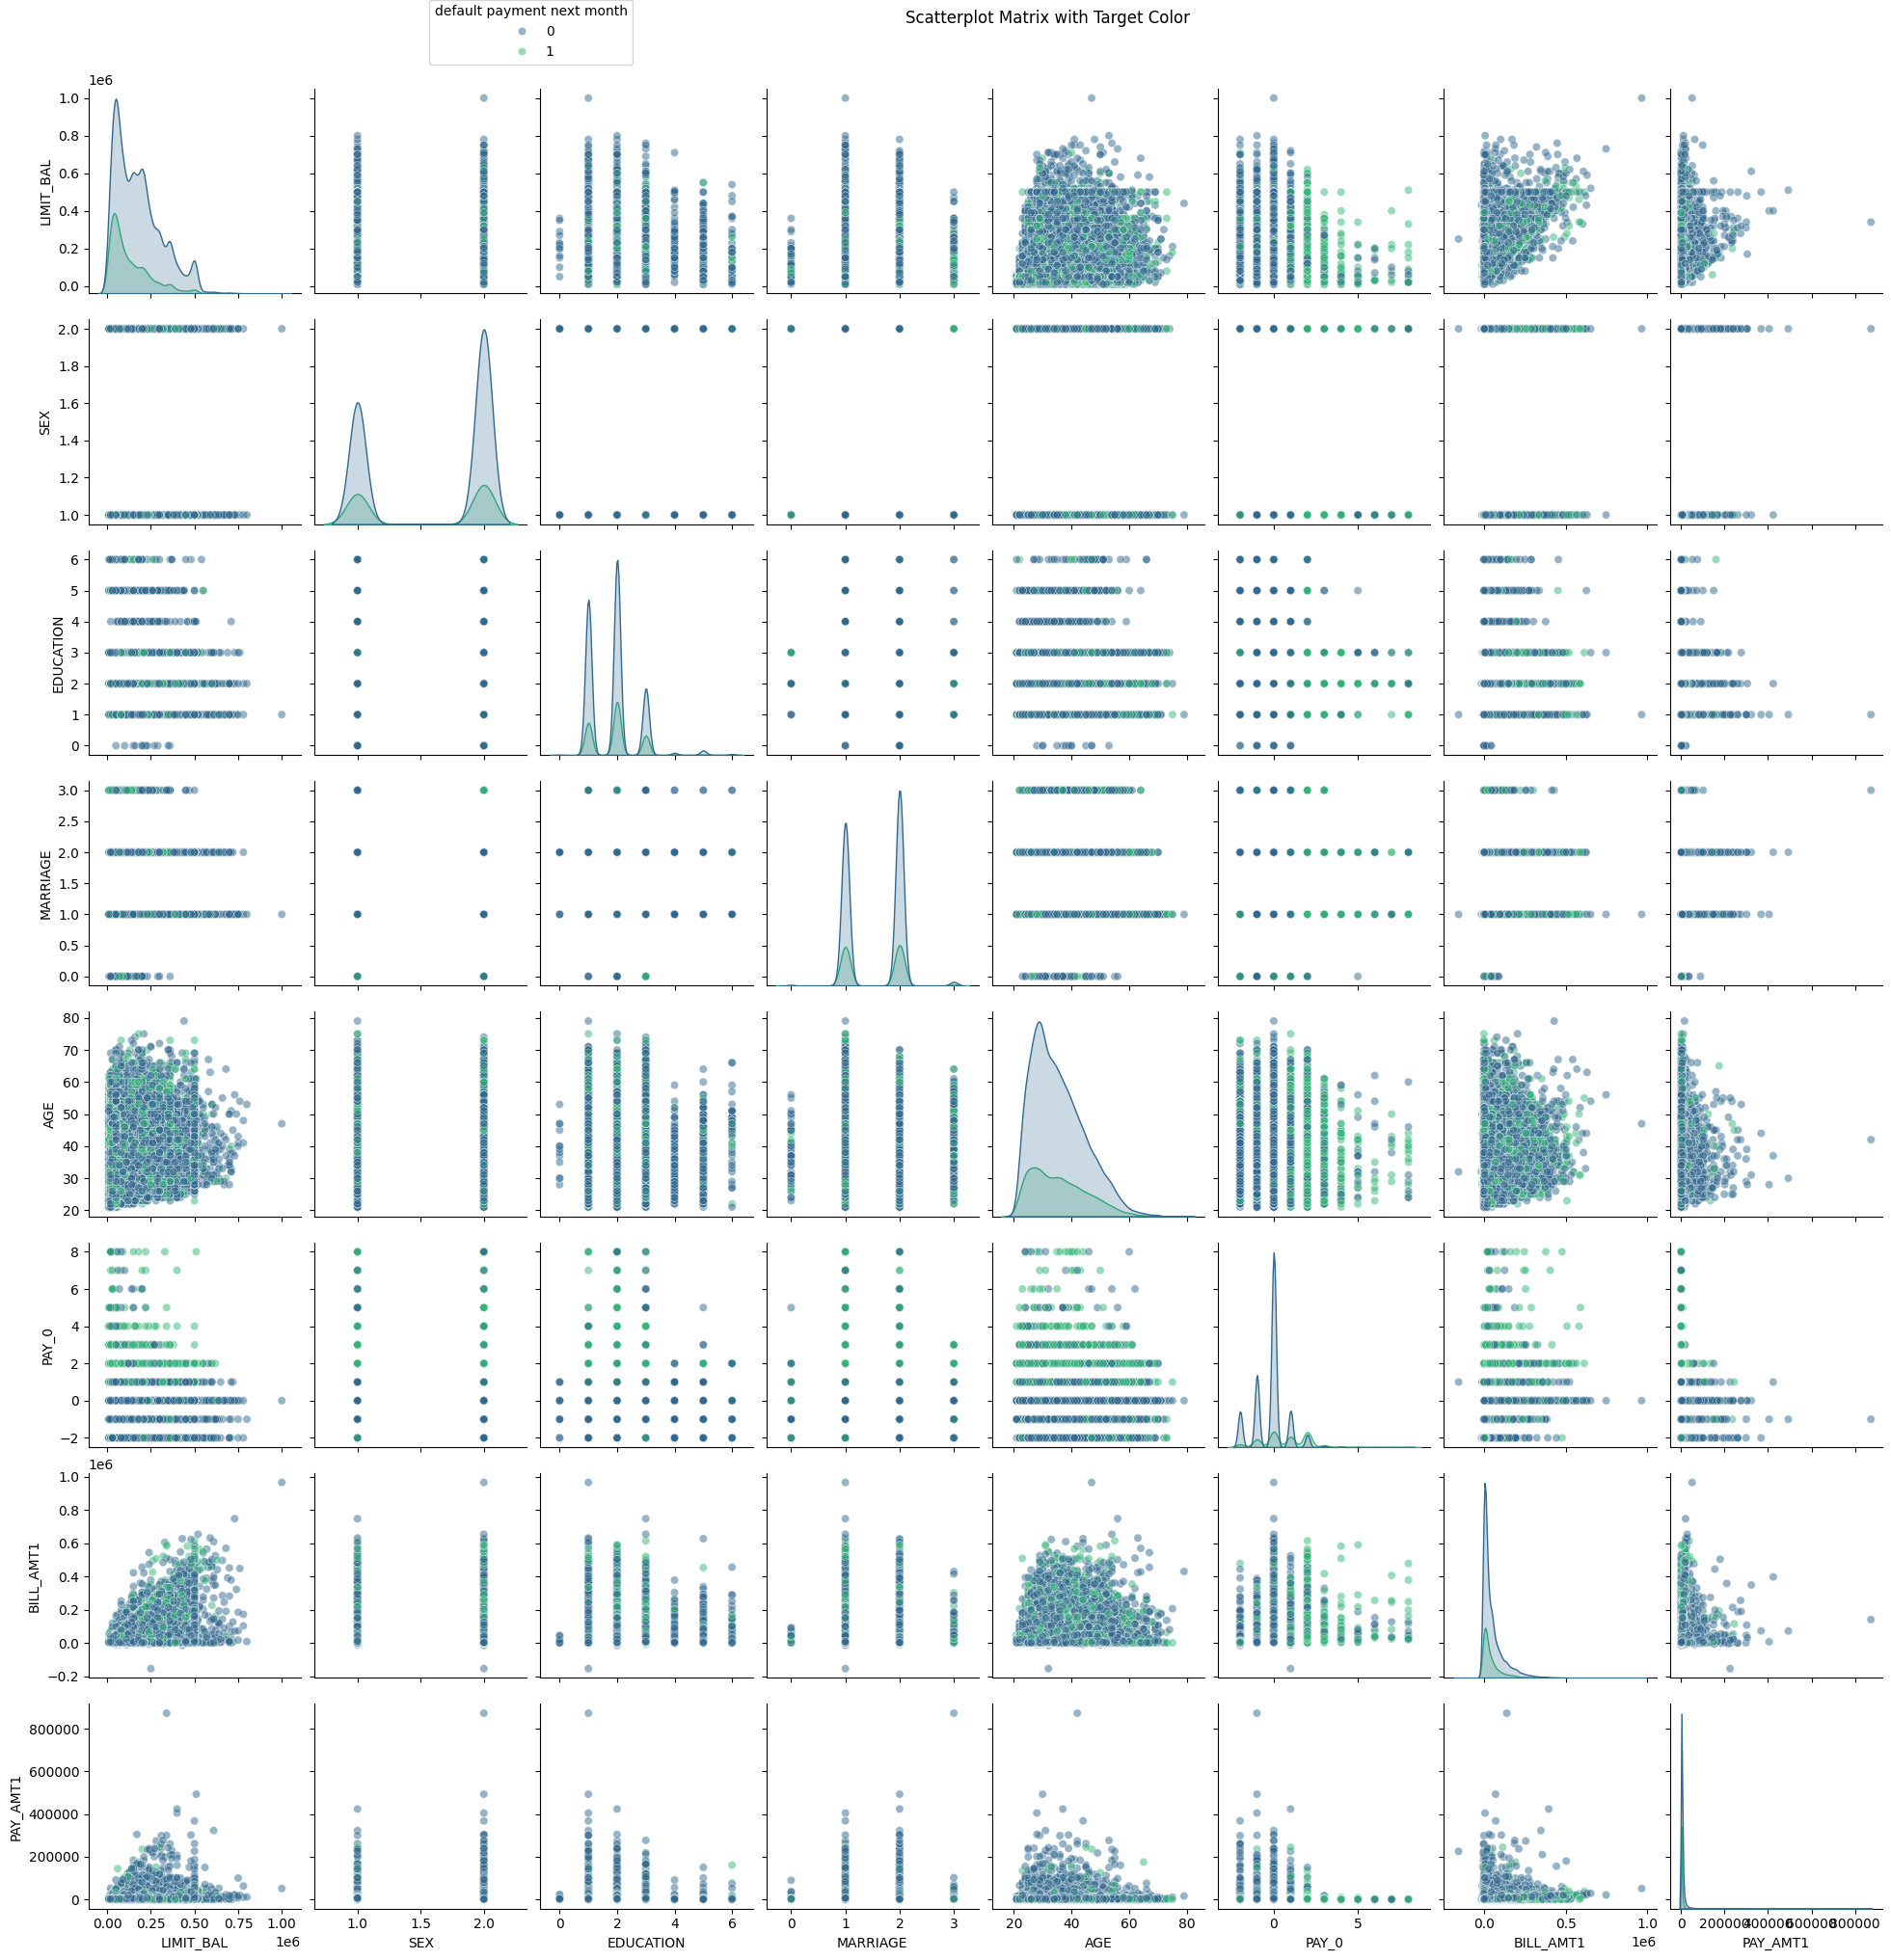

In [37]:
# Select a subset of features for the scatterplot matrix (pair plot)
selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'BILL_AMT1', 'PAY_AMT1', target_col]

# Create a pair plot with the selected features, colored by the target variable
pairplot = sns.pairplot(train_data[selected_features], hue=target_col, palette="viridis", diag_kind="kde", plot_kws={'alpha': 0.5})

# Put the legend at the top to avoid making the image larger
pairplot._legend.set_bbox_to_anchor((0.3, 1))
pairplot._legend.set_title(target_col)
pairplot._legend.set_frame_on(True)

# Display the plot
plt.suptitle("Scatterplot Matrix with Target Color", y=1.02)
plt.show()

From the scatterplot matrix, if we focus on PAY_0 we can see when it's greater or equal to 2 the target is more likely to be 1 (default payment next month).

This means **if the payment delay in September is at least 2 months**.

## Preparing the data

### Data Cleaning

In [13]:
# See what's the shape we start with, to compare before and after Data Cleaning
train_data.shape

(25500, 24)

Let's clean the training set, according to the analysis made before.

Before performing Data Cleaning, we have 25500 rows and 23 features (1 is the target).

#### Clipping inconsistencies

We'll start by clipping the features which have inconsistencies.

In [208]:
# EDUCATION: clip to range [1, 4]
train_data['EDUCATION'] = train_data['EDUCATION'].clip(lower=1, upper=4)

# MARRIAGE: clip to range [1, 3]
train_data['MARRIAGE'] = train_data['MARRIAGE'].clip(lower=1, upper=3)

# PAY_0 to PAY_6: clip each to range [-1, 9]
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in pay_columns:
    train_data[col] = train_data[col].clip(lower=-1, upper=9)

# BILL_AMT1 to BILL_AMT6: clip each to minimum 0 (no negative values)
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
for col in bill_columns:
    train_data[col] = train_data[col].clip(lower=0)

In [15]:
# Make sure everything is consistent now

get_inconsistency_df(train_data)

Number of Inconsistencies
Feature                             
LIMIT_BAL                          0
SEX                                0
EDUCATION                          0
MARRIAGE                           0
AGE                                0
PAY_0                              0
PAY_2                              0
PAY_3                              0
PAY_4                              0
PAY_5                              0
PAY_6                              0
BILL_AMT1                          0
BILL_AMT2                          0
BILL_AMT3                          0
BILL_AMT4                          0
BILL_AMT5                          0
BILL_AMT6                          0
PAY_AMT1                           0
PAY_AMT2                           0
PAY_AMT3                           0
PAY_AMT4                           0
PAY_AMT5                           0
PAY_AMT6                           0

#### Remove duplicate rows

We don't need the duplicate rows which won't add information to the model.

In [209]:
# Exclude duplicate rows from train_data
train_data = train_data[~train_data.duplicated()]

In [17]:
# Make sure everything is not duplicate now
train_data[train_data.duplicated()]

Empty DataFrame
Columns: [LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, default payment next month]
Index: []

[0 rows x 24 columns]

In [18]:
# New number of rows: we excluded 25 rows
train_data.shape[0]

25475

We now have 25475 rows: this means that 25 rows were removed from the training set.

#### Drop SEX, EDUCATION, MARRIAGE, AGE

As seen before, these features don't add information to the target: let's exclude them from the training set.

In [210]:
# Exclude SEX, EDUCATION, MARRIAGE, AGE from train_data
train_data = train_data.drop(columns=['SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])

In [20]:
# New train_data shape
train_data.shape

(25475, 20)

In [21]:
train_data

LIMIT_BAL  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0         200000     -1     -1     -1     -1     -1     -1       2571   
1         230000      0      0      0      0      0      0     234328   
2          50000      0      0      0      0      0      0      48080   
3          20000      0      0     -1     -1     -1     -1      16809   
4          30000      1      2      2      2      2      0      28084   
...          ...    ...    ...    ...    ...    ...    ...        ...   
25495     480000      0      0      0      0      0      0      44018   
25496     200000      0     -1     -1     -1     -1     -1       1290   
25497     450000     -1     -1     -1     -1     -1     -1       8940   
25498     230000      0      0      0      0      0      0     149697   
25499      70000     -1     -1     -1     -1      0      0       2226   

       BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0           2772       2571       2571       2571       2571      2772   
1         234211     157345     155335     153427     150514      8913   
2          48062      48667      49311      24663      24854      1763   
3              0          0          0          0          0         0   
4          29299      28741      30467      29858      28898      1950   
...          ...        ...        ...        ...        ...       ...   
25495      74152     107675     110289     100520      37080     35176   
25496        599          0        253          0          0       599   
25497       6239       5535       9856        819        863      6271   
25498     155697     165978     170563     173697     179697      6000   
25499       1245          0      11019      11632       7864      1245   

       PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          2571      2571      2571      2571      2571   
1          5449      5339      5370      4435      4432   
2          2112      1756       324       336       351   
3             0         0         0         0         0   
4           200      2492         0       580         0   
...         ...       ...       ...       ...       ...   
25495     45000     12022     14000     14000     10000   
25496         0       253         0         0         0   
25497      5740      9905       823       867      2488   
25498     10281      8866      6000      6000      6000   
25499         0     12019      1000       157      7851   

       default payment next month  
0                               0  
1                               1  
2                               0  
3                               1  
4                               1  
...                           ...  
25495                           0  
25496                           0  
25497                           0  
25498                           0  
25499                           0  

[25475 rows x 20 columns]

#### Log scaling

We'll now perform log scaling on the remaining features (except for PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, which are categorical) to improve the distributions.

We'll clone the training set to be able to compare the performance results using both approaches (scaling and no scaling).

In [211]:
# Perform log scaling on the features in train_data excluding the specified columns
excluded_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default payment next month']
features_to_scale = [col for col in train_data.columns if col not in excluded_columns]

# Apply log scaling
train_data_scaled = train_data.copy()
train_data_scaled[features_to_scale] = np.log1p(train_data[features_to_scale])

In [25]:
# Scaled training set
train_data_scaled

LIMIT_BAL PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6  BILL_AMT1  BILL_AMT2  \
0      12.206078    -1    -1    -1    -1    -1    -1   7.852439   7.927685   
1      12.345839     0     0     0     0     0     0  12.364481  12.363982   
2      10.819798     0     0     0     0     0     0  10.780642  10.780268   
3       9.903538     0     0    -1    -1    -1    -1   9.729729   0.000000   
4      10.308986     1     2     2     2     2     0  10.242991  10.285343   
...          ...   ...   ...   ...   ...   ...   ...        ...        ...   
25495  13.081543     0     0     0     0     0     0  10.692377  11.213886   
25496  12.206078     0    -1    -1    -1    -1    -1   7.163172   6.396930   
25497  13.017005    -1    -1    -1    -1    -1    -1   9.098403   8.738735   
25498  12.345839     0     0     0     0     0     0  11.916375  11.955674   
25499  11.156265    -1    -1    -1    -1     0     0   7.708411   7.127694   

       BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6   PAY_AMT1   PAY_AMT2  \
0       7.852439   7.852439   7.852439   7.852439   7.927685   7.852439   
1      11.966202  11.953346  11.940987  11.921818   9.095378   8.603371   
2      10.792777  10.805923  10.113100  10.120814   7.475339   7.655864   
3       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4      10.266115  10.324432  10.304242  10.271562   7.576097   5.303305   
...          ...        ...        ...        ...        ...        ...   
25495  11.586882  11.610869  11.518122  10.520860  10.468148  10.714440   
25496   0.000000   5.537334   0.000000   0.000000   6.396930   0.000000   
25497   8.619027   9.195937   6.709304   6.761573   8.743851   8.655389   
25498  12.019617  12.046866  12.065073  12.099033   8.699681   9.238150   
25499   0.000000   9.307467   9.361601   8.970178   7.127694   0.000000   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0      7.852439  7.852439  7.852439  7.852439                           0  
1      8.582981  8.588769  8.397508  8.396832                           1  
2      7.471363  5.783825  5.820083  5.863631                           0  
3      0.000000  0.000000  0.000000  0.000000                           1  
4      7.821242  0.000000  6.364751  0.000000                           1  
...         ...       ...       ...       ...                         ...  
25495  9.394577  9.546884  9.546884  9.210440                           0  
25496  5.537334  0.000000  0.000000  0.000000                           0  
25497  9.200896  6.714171  6.766192  7.819636                           0  
25498  9.090092  8.699681  8.699681  8.699681                           0  
25499  9.394327  6.908755  5.062595  8.968524                           0  

[25475 rows x 20 columns]

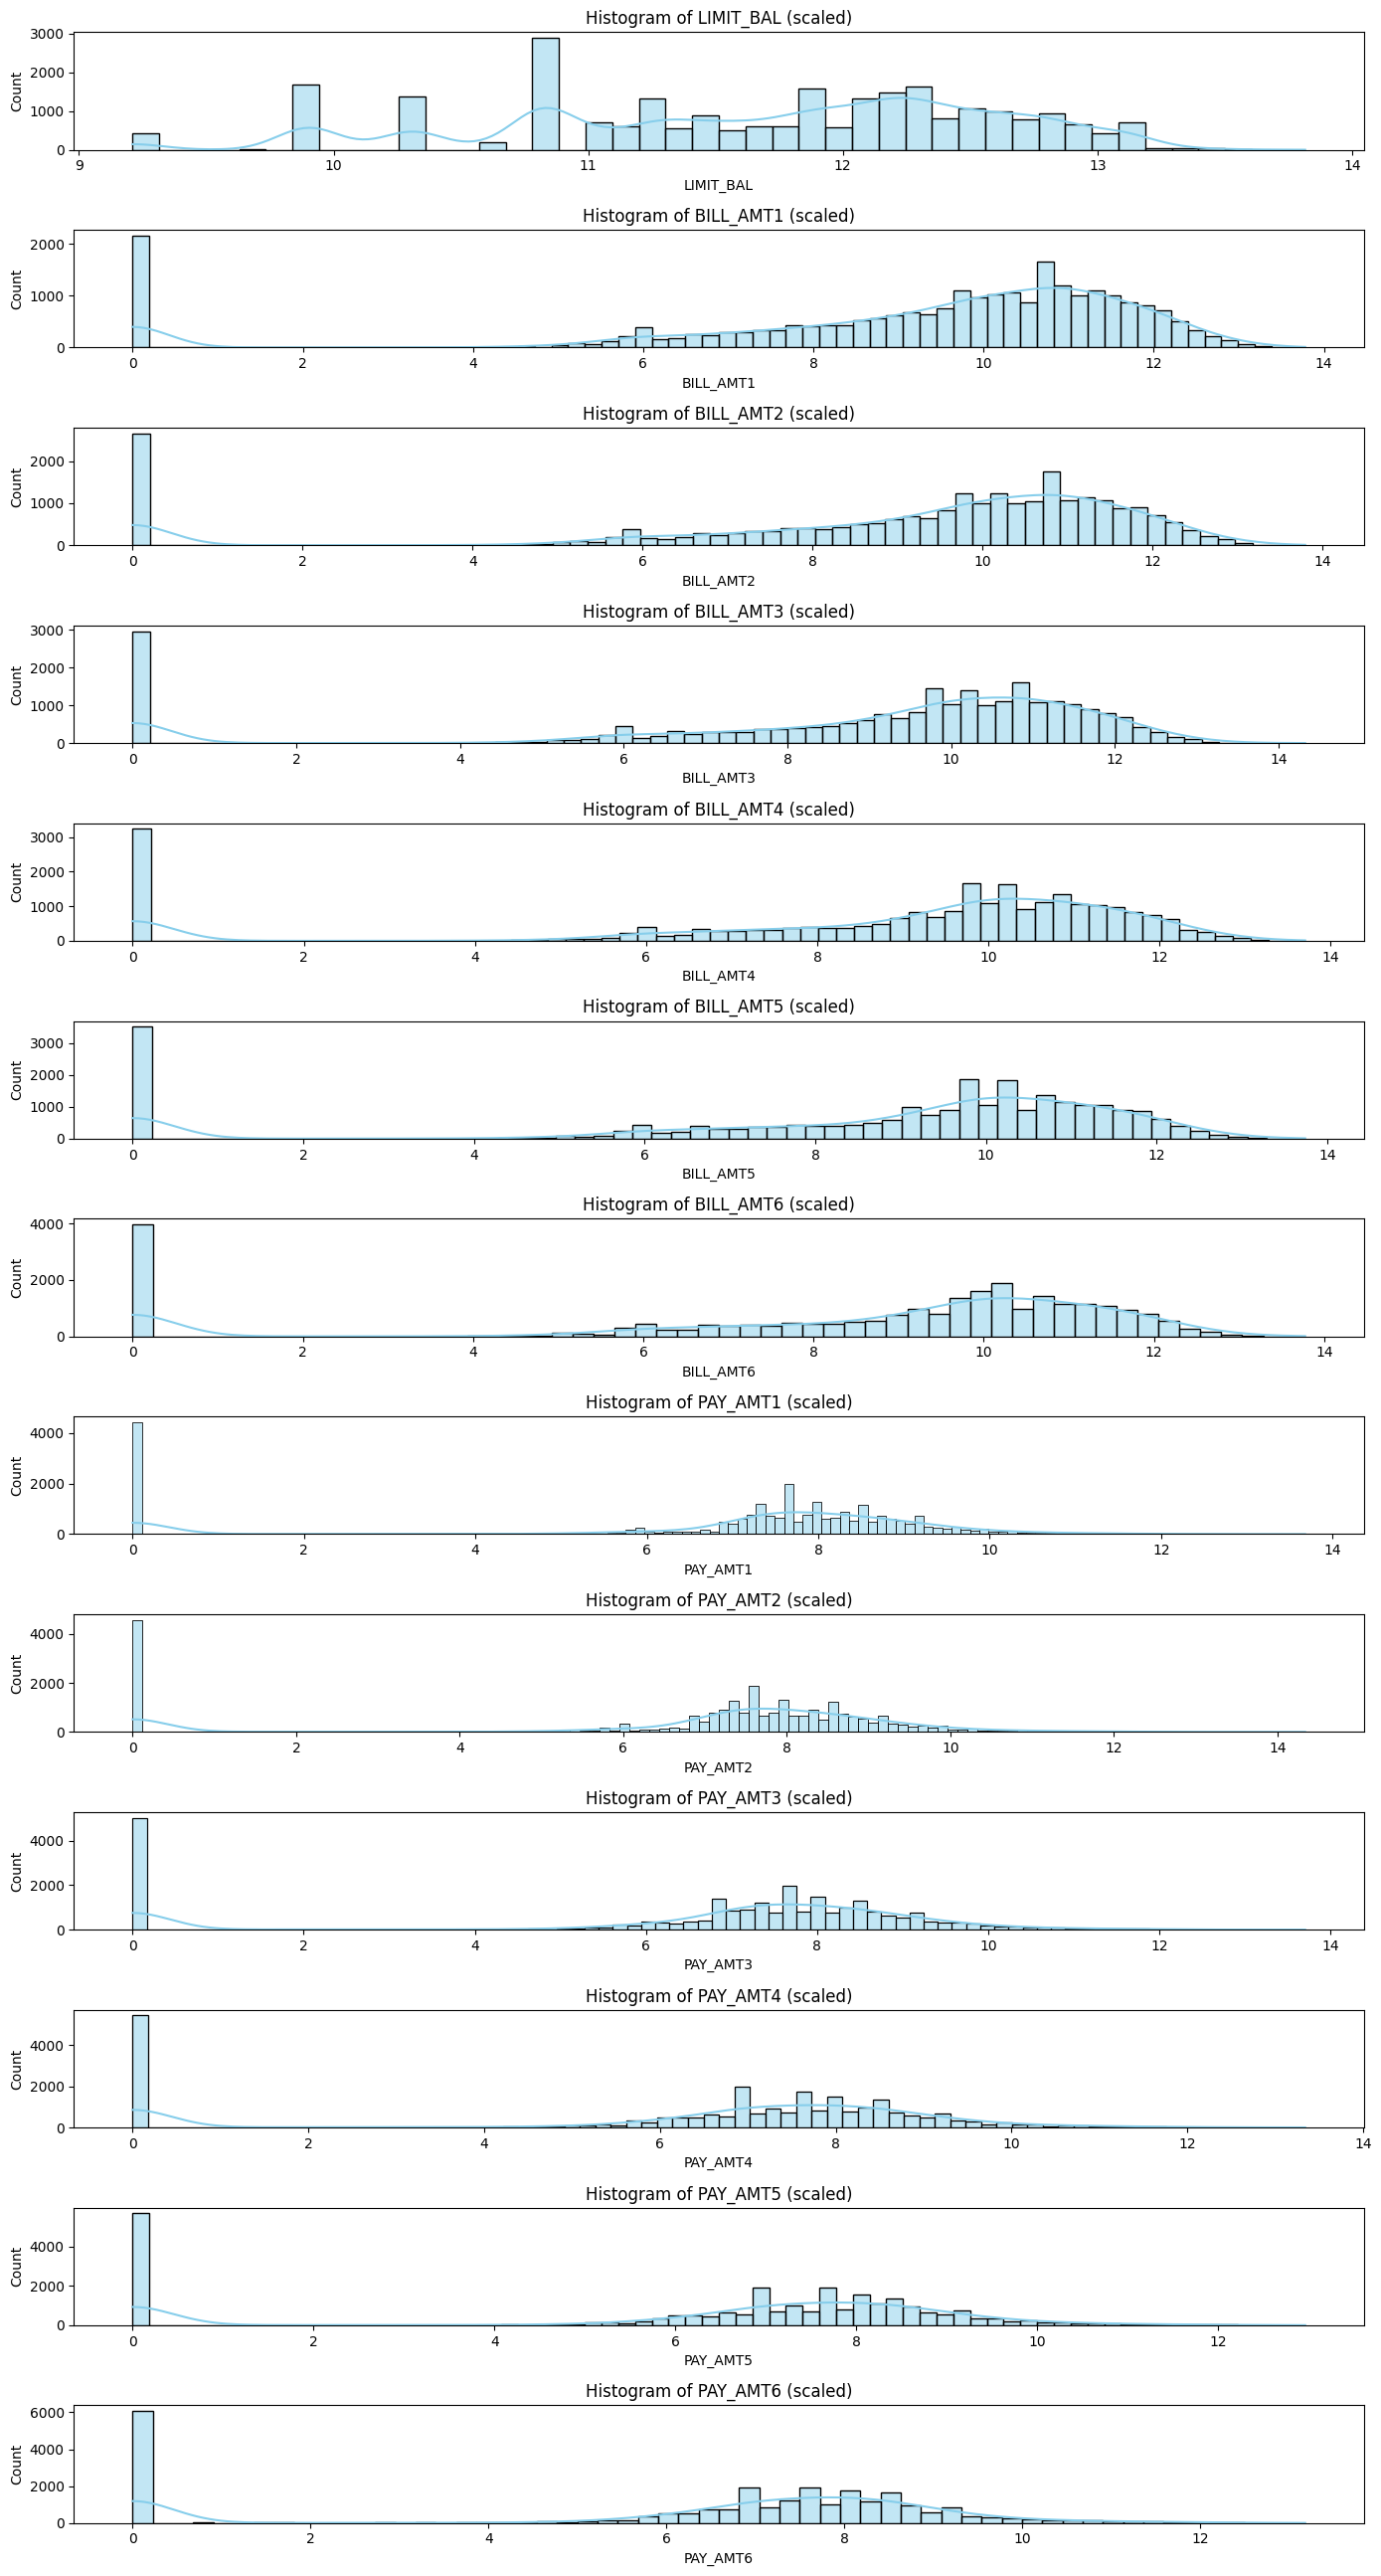

In [88]:
# Plot the distributions of the scaled features
fig, axes = plt.subplots(len(features_to_scale), 1, figsize=(14, len(features_to_scale) * 2))

for i, feature in enumerate(features_to_scale):
    # Histogram
    sns.histplot(train_data_scaled[feature], kde=True, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Histogram of {feature} (scaled)")
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

This looks much better than before: our hope is that the Neural Networks perform better on the scaled data.

To summarize, we now have two training sets: train_data and train_data_scaled.

In [26]:
# No scaling
train_data

LIMIT_BAL PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6  BILL_AMT1  BILL_AMT2  \
0         200000    -1    -1    -1    -1    -1    -1       2571       2772   
1         230000     0     0     0     0     0     0     234328     234211   
2          50000     0     0     0     0     0     0      48080      48062   
3          20000     0     0    -1    -1    -1    -1      16809          0   
4          30000     1     2     2     2     2     0      28084      29299   
...          ...   ...   ...   ...   ...   ...   ...        ...        ...   
25495     480000     0     0     0     0     0     0      44018      74152   
25496     200000     0    -1    -1    -1    -1    -1       1290        599   
25497     450000    -1    -1    -1    -1    -1    -1       8940       6239   
25498     230000     0     0     0     0     0     0     149697     155697   
25499      70000    -1    -1    -1    -1     0     0       2226       1245   

       BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0           2571       2571       2571       2571      2772      2571   
1         157345     155335     153427     150514      8913      5449   
2          48667      49311      24663      24854      1763      2112   
3              0          0          0          0         0         0   
4          28741      30467      29858      28898      1950       200   
...          ...        ...        ...        ...       ...       ...   
25495     107675     110289     100520      37080     35176     45000   
25496          0        253          0          0       599         0   
25497       5535       9856        819        863      6271      5740   
25498     165978     170563     173697     179697      6000     10281   
25499          0      11019      11632       7864      1245         0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0          2571      2571      2571      2571                           0  
1          5339      5370      4435      4432                           1  
2          1756       324       336       351                           0  
3             0         0         0         0                           1  
4          2492         0       580         0                           1  
...         ...       ...       ...       ...                         ...  
25495     12022     14000     14000     10000                           0  
25496       253         0         0         0                           0  
25497      9905       823       867      2488                           0  
25498      8866      6000      6000      6000                           0  
25499     12019      1000       157      7851                           0  

[25475 rows x 20 columns]

In [27]:
# Scaling
train_data

LIMIT_BAL PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6  BILL_AMT1  BILL_AMT2  \
0         200000    -1    -1    -1    -1    -1    -1       2571       2772   
1         230000     0     0     0     0     0     0     234328     234211   
2          50000     0     0     0     0     0     0      48080      48062   
3          20000     0     0    -1    -1    -1    -1      16809          0   
4          30000     1     2     2     2     2     0      28084      29299   
...          ...   ...   ...   ...   ...   ...   ...        ...        ...   
25495     480000     0     0     0     0     0     0      44018      74152   
25496     200000     0    -1    -1    -1    -1    -1       1290        599   
25497     450000    -1    -1    -1    -1    -1    -1       8940       6239   
25498     230000     0     0     0     0     0     0     149697     155697   
25499      70000    -1    -1    -1    -1     0     0       2226       1245   

       BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0           2571       2571       2571       2571      2772      2571   
1         157345     155335     153427     150514      8913      5449   
2          48667      49311      24663      24854      1763      2112   
3              0          0          0          0         0         0   
4          28741      30467      29858      28898      1950       200   
...          ...        ...        ...        ...       ...       ...   
25495     107675     110289     100520      37080     35176     45000   
25496          0        253          0          0       599         0   
25497       5535       9856        819        863      6271      5740   
25498     165978     170563     173697     179697      6000     10281   
25499          0      11019      11632       7864      1245         0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0          2571      2571      2571      2571                           0  
1          5339      5370      4435      4432                           1  
2          1756       324       336       351                           0  
3             0         0         0         0                           1  
4          2492         0       580         0                           1  
...         ...       ...       ...       ...                         ...  
25495     12022     14000     14000     10000                           0  
25496       253         0         0         0                           0  
25497      9905       823       867      2488                           0  
25498      8866      6000      6000      6000                           0  
25499     12019      1000       157      7851                           0  

[25475 rows x 20 columns]

## Baseline model

Before experimenting with Neural Networks, let's create the baseline model we talked about before!

We said our intuition is that when the payment delay in September (PAY_0) is at least 2 months, then we consider a default payment in the next month.

In [28]:
def simple_classifier(row):
    if row['PAY_0'] >= 2:
        return 1 
    else:
        return 0

### Baseline model evaluation

Let's perform the classification and calculate some metrics on both the training set and the test set (using the assessment page)!

#### Training Set

In [29]:
# Apply the classifier to each row in train_data to get predictions
baseline_train_predictions = train_data.apply(simple_classifier, axis=1)

# Calculate metrics
baseline_train_accuracy = accuracy_score(train_data['default payment next month'], baseline_train_predictions)
baseline_train_precision = precision_score(train_data['default payment next month'], baseline_train_predictions)
baseline_train_recall = recall_score(train_data['default payment next month'], baseline_train_predictions)
baseline_train_f1_score = f1_score(train_data['default payment next month'], baseline_train_predictions)

# Display the results
print(f"(Baseline) Training accuracy: {baseline_train_accuracy}")
print(f"(Baseline) Training precision: {baseline_train_precision}")
print(f"(Baseline) Training recall: {baseline_train_recall}")
print(f"(Baseline) Training f1_score: {baseline_train_f1_score}")

(Baseline) Training accuracy: 0.817585868498528
(Baseline) Training precision: 0.6930841121495327
(Baseline) Training recall: 0.32640845070422536
(Baseline) Training f1_score: 0.4438061041292639


The baseline model has decent accuracy at 81.76%, but its recall is quite low at 32.64%. 

This means it misses many actual defaulters, which is critical for this task. Precision is fair at 69.31%, so when it predicts a default, it’s often correct. 

While accuracy looks good, the low recall suggests we need a better model to catch more true defaulters.

By the way, let's see how it performs on the test set!

#### Test Set

In [212]:
# Load the test data
test_data = pd.read_csv('test.csv')

test_data

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0      9956     180000    2          2         1   32     -1      2     -1   
1       879      50000    2          2         1   43      0      0      0   
2       554     240000    2          1         1   42      1     -1     -1   
3       142     180000    1          2         2   28     -1     -1     -1   
4     14630     320000    2          1         1   39      0      0      0   
...     ...        ...  ...        ...       ...  ...    ...    ...    ...   
4495  25109     230000    1          2         1   60      0      0      0   
4496  20765      20000    1          2         1   46      0      0      0   
4497  26681      90000    1          3         2   27      2      2      2   
4498  25943     200000    2          1         1   33      2     -1     -1   
4499  25470     150000    2          5         1   34      0      0      0   

      PAY_4  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0         0  ...       7658       1000       1650       1000         0   
1        -1  ...      20165      10732      10566      10757      1800   
2        -2  ...          0          0          0          0      6370   
3        -1  ...        832        332        416        416         0   
4         0  ...     128832     133329      53870      13185      5000   
...     ...  ...        ...        ...        ...        ...       ...   
4495      0  ...     133281     123958     124474     120570      6057   
4496      0  ...      19442      14678      16791      10361      1363   
4497      2  ...      91898      91334      59253      58519      4500   
4498     -1  ...        316       1076        316       1226       696   
4499      0  ...      93000      98000     100000          0      5000   

      PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
0         7667         0      1650      1000      2000  
1         1775     10732       384       757       501  
2            0         0         0         0         0  
3          416       332       500      3500       832  
4        15000      5000      5000      3000      5000  
...        ...       ...       ...       ...       ...  
4495      4845      4291      4115      4274      4054  
4496      1256      1178       311      2264         0  
4497      4000      2090         0      2078      2900  
4498       316      1076       316      1226       696  
4499      5000      5000      2000         0         0  

[4500 rows x 24 columns]

In [31]:
# Apply the classifier to each row in test_data to get predictions
baseline_test_predictions = test_data.apply(simple_classifier, axis=1)

baseline_test_predictions

0       0
1       0
2       0
3       0
4       0
       ..
4495    0
4496    0
4497    1
4498    1
4499    0
Length: 4500, dtype: int64

In [32]:
# See how the target distribution was predicted on the test data
baseline_test_predictions.value_counts()

0    4045
1     455
dtype: int64

On the assessment page, we can see some anonymous student has already tried sending a csv with only zeros to the assessment page, to see the actual test distribution exploiting the accuracy.

This is his *(I guess it's a he, since the name is OnlyZeroGuy)* result:

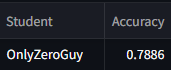

This means that ~0.7886 (test accuracy with only zeros) * 4500 (number of test rows) = ~**3548** rows (78.86%) in test set have the **label 0**, while ~**952** rows in the test set have the **label 1**.

Let's export the test predictions and send them to the assessment page.

In [33]:
# Save it in the appropriate format (csv with no index and no header)
baseline_test_predictions.to_csv('baseline_test_predictions.csv', index=False, header=False)

This is how it performs on the **assessment page**, check "CP_no_machine_learning" ("lol" was still me, on the first try)

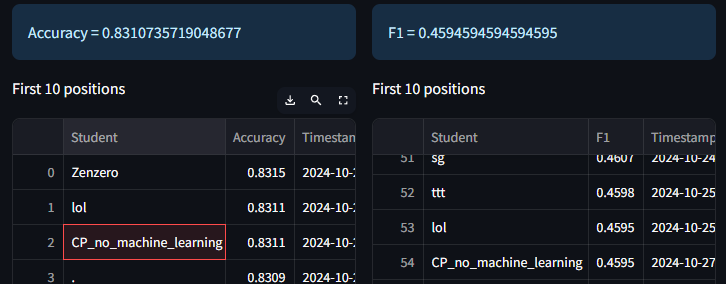

We can say the test and the train follow a similar distribution, since the results are pretty similar.

It confirms our baseline model is not "predicting" enough rows of the positive class, that's why the recall is pretty low (high FN).

The comment made for the training is still valid: the test accuracy (83.11%) is good, but sadly the test f1 score (45.95%) is not that great.

Let's experiment with Neural Networks!

## Building the network

Let's experiment with Neural Networks, first with the **scaled training set** and then **the one that wasn't scaled**: we'll create models of varying complexities for the two training sets.

We'll use a Feed-Forward Neural Network with **1, 2 or 3** hidden layers: increasing layers or units can help capture eventual complex relationships but at the risk of overfitting.

We'll experiment with **32, 64 and 128 units** and we'll use **ReLU for hidden layers** as it's computationally efficient.

Since it's a binary classification, for the output layer we'll use a single unit with a **Sigmoid** activation function, optimal for outputting probabilities in binary tasks. We'll use **Binary Cross-Entropy** as the loss function, ideal for binary classification.

About the optimizer, we'll use **Adam**, which is robust and helps manage gradient issues that could arise. 
We'll use a **learning rate of 0.001**, which is commonly used to balance convergence speed and stability.

These are the models that will be created for both train_data and train_data_scaled:
- FFNN with 1 hidden layer of 32 units (**model 1**)
- FFNN with 2 hidden layers, each with 64 units (**model 2**)
- FFNN with 3 hidden layers of 128, 64 and 32 units. (**model 3**)

### Common for all models

In [44]:
# The input dimension is the number of features
input_dim = train_data_scaled.shape[1] - 1
print(f"Input dimension for all the models: {input_dim}")

Input dimension for all the models: 19


In [135]:
# True labels
y_true = train_data_scaled.iloc[:, -1].values

In [150]:
# Functions to plot loss and accuracy curves, useful for later

def plot_loss(history, title="Loss"):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history, title="Accuracy"):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

### Scaled training set

Quick reminder: here is the scaled training set

In [34]:
train_data_scaled

LIMIT_BAL PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6  BILL_AMT1  BILL_AMT2  \
0      12.206078    -1    -1    -1    -1    -1    -1   7.852439   7.927685   
1      12.345839     0     0     0     0     0     0  12.364481  12.363982   
2      10.819798     0     0     0     0     0     0  10.780642  10.780268   
3       9.903538     0     0    -1    -1    -1    -1   9.729729   0.000000   
4      10.308986     1     2     2     2     2     0  10.242991  10.285343   
...          ...   ...   ...   ...   ...   ...   ...        ...        ...   
25495  13.081543     0     0     0     0     0     0  10.692377  11.213886   
25496  12.206078     0    -1    -1    -1    -1    -1   7.163172   6.396930   
25497  13.017005    -1    -1    -1    -1    -1    -1   9.098403   8.738735   
25498  12.345839     0     0     0     0     0     0  11.916375  11.955674   
25499  11.156265    -1    -1    -1    -1     0     0   7.708411   7.127694   

       BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6   PAY_AMT1   PAY_AMT2  \
0       7.852439   7.852439   7.852439   7.852439   7.927685   7.852439   
1      11.966202  11.953346  11.940987  11.921818   9.095378   8.603371   
2      10.792777  10.805923  10.113100  10.120814   7.475339   7.655864   
3       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4      10.266115  10.324432  10.304242  10.271562   7.576097   5.303305   
...          ...        ...        ...        ...        ...        ...   
25495  11.586882  11.610869  11.518122  10.520860  10.468148  10.714440   
25496   0.000000   5.537334   0.000000   0.000000   6.396930   0.000000   
25497   8.619027   9.195937   6.709304   6.761573   8.743851   8.655389   
25498  12.019617  12.046866  12.065073  12.099033   8.699681   9.238150   
25499   0.000000   9.307467   9.361601   8.970178   7.127694   0.000000   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0      7.852439  7.852439  7.852439  7.852439                           0  
1      8.582981  8.588769  8.397508  8.396832                           1  
2      7.471363  5.783825  5.820083  5.863631                           0  
3      0.000000  0.000000  0.000000  0.000000                           1  
4      7.821242  0.000000  6.364751  0.000000                           1  
...         ...       ...       ...       ...                         ...  
25495  9.394577  9.546884  9.546884  9.210440                           0  
25496  5.537334  0.000000  0.000000  0.000000                           0  
25497  9.200896  6.714171  6.766192  7.819636                           0  
25498  9.090092  8.699681  8.699681  8.699681                           0  
25499  9.394327  6.908755  5.062595  8.968524                           0  

[25475 rows x 20 columns]

#### Model 1 (scaled train)

In [132]:
# Model 1: FFNN with 1 hidden layer of 32 units
model_1_scaled = Sequential()
model_1_scaled.add(Input(shape=(input_dim,)))
model_1_scaled.add(Dense(32, activation='relu'))
model_1_scaled.add(Dense(1, activation='sigmoid'))

# Compile the model
model_1_scaled.compile(optimizer=Adam(learning_rate=0.001), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy', 'recall'])

# Summary of the model
model_1_scaled.summary()

# Fit the model
history_1_scaled = model_1_scaled.fit(
    train_data_scaled.iloc[:, :-1],  # x_train_scaled
    train_data_scaled.iloc[:, -1],   # y_train_scaled
    batch_size=128,
    epochs=20,
    validation_split=0.2
)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673 (2.63 KB)

 Trainable params: 673 (2.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5313 - loss: 2.2265 - recall: 0.5707 - val_accuracy: 0.7702 - val_loss: 0.5464 - val_recall: 0.3301
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.5182 - recall: 0.2959 - val_accuracy: 0.7949 - val_loss: 0.4968 - val_recall: 0.3057
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4832 - recall: 0.2810 - val_accuracy: 0.8055 - val_loss: 0.4713 - val_recall: 0.3145
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.4660 - recall: 0.2850 - val_accuracy: 0.8102 - val_loss: 0.4631 - val_recall: 0.3293
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8048 - loss: 0.4607 - recall: 0.2926 - val_accuracy: 0.8132 - val_loss: 0.4591 - val_recall: 0.3389
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8053 - loss: 0.4580 - recall: 0.2941 - val_accuracy: 0.8149 - val_loss: 0.4565 - val_recall: 0.3441
Epoc

In [136]:
# Make predictions on the training data
y_pred_1_scaled = model_1_scaled.predict(train_data_scaled.iloc[:, :-1])
y_pred_1_scaled = (y_pred_1_scaled > 0.5).astype(int)

# Calculate the metrics
model_1_scaled_train_accuracy = accuracy_score(y_true, y_pred_1_scaled)
model_1_scaled_train_precision = precision_score(y_true, y_pred_1_scaled)
model_1_scaled_train_recall = recall_score(y_true, y_pred_1_scaled)
model_1_scaled_train_f1_score = f1_score(y_true, y_pred_1_scaled)

# Display the results
print("(Model 1 - scaled train) Training accuracy:", model_1_scaled_train_accuracy)
print("(Model 1 - scaled train) Training precision:", model_1_scaled_train_precision)
print("(Model 1 - scaled train) Training recall:", model_1_scaled_train_recall)
print("(Model 1 - scaled train) Training f1_score:", model_1_scaled_train_f1_score)

797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(Model 1 - scaled train) Training accuracy: 0.8164082433758587
(Model 1 - scaled train) Training precision: 0.6544502617801047
(Model 1 - scaled train) Training recall: 0.37411971830985913
(Model 1 - scaled train) Training f1_score: 0.4760837907471715


#### Model 2 (scaled train)

In [146]:
# Model 2: FFNN with 2 hidden layers, each with 64 units
model_2_scaled = Sequential()
model_2_scaled.add(Input(shape=(input_dim,)))
model_2_scaled.add(Dense(64, activation='relu'))
model_2_scaled.add(Dense(64, activation='relu'))
model_2_scaled.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2_scaled.compile(optimizer=Adam(learning_rate=0.001), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy', 'recall'])

# Summary of the model
model_2_scaled.summary()

# Fit the model
history_2_scaled = model_2_scaled.fit(
    train_data_scaled.iloc[:, :-1],  # x_train_scaled
    train_data_scaled.iloc[:, -1],   # y_train_scaled
    batch_size=128,
    epochs=20,
    validation_split=0.2
)

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,505 (21.50 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6926 - loss: 0.8951 - recall: 0.2484 - val_accuracy: 0.8096 - val_loss: 0.4524 - val_recall: 0.3101
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.4558 - recall: 0.2823 - val_accuracy: 0.8104 - val_loss: 0.4476 - val_recall: 0.3336
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.4497 - recall: 0.3051 - val_accuracy: 0.8124 - val_loss: 0.4446 - val_recall: 0.3589
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8096 - loss: 0.4462 - recall: 0.3224 - val_accuracy: 0.8153 - val_loss: 0.4437 - val_recall: 0.3876
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8115 - loss: 0.4445 - recall: 0.3382 - val_accuracy: 0.8169 - val_loss: 0.4429 - val_recall: 0.4016
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8122 - loss: 0.4430 - recall: 0.3480 - val_accuracy: 0.8165 - val_loss: 0.4420 - val_recall: 0.4016
Epoc

In [149]:
# Make predictions on the training data
y_pred_2_scaled = model_2_scaled.predict(train_data_scaled.iloc[:, :-1])
y_pred_2_scaled = (y_pred_2_scaled > 0.5).astype(int)

# Calculate the metrics
model_2_scaled_train_accuracy = accuracy_score(y_true, y_pred_2_scaled)
model_2_scaled_train_precision = precision_score(y_true, y_pred_2_scaled)
model_2_scaled_train_recall = recall_score(y_true, y_pred_2_scaled)
model_2_scaled_train_f1_score = f1_score(y_true, y_pred_2_scaled)

# Display the results
print("(Model 2 - scaled train) Training accuracy:", model_2_scaled_train_accuracy)
print("(Model 2 - scaled train) Training precision:", model_2_scaled_train_precision)
print("(Model 2 - scaled train) Training recall:", model_2_scaled_train_recall)
print("(Model 2 - scaled train) Training f1_score:", model_2_scaled_train_f1_score)

797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(Model 2 - scaled train) Training accuracy: 0.8215112855740923
(Model 2 - scaled train) Training precision: 0.6654981010809232
(Model 2 - scaled train) Training recall: 0.40105633802816903
(Model 2 - scaled train) Training f1_score: 0.5004943425244425


#### Model 3 (scaled train)

In [151]:
# Model 3: FFNN with 3 hidden layers (128, 64, 32 units)
model_3_scaled = Sequential()
model_3_scaled.add(Input(shape=(input_dim,)))
model_3_scaled.add(Dense(128, activation='relu'))
model_3_scaled.add(Dense(64, activation='relu'))
model_3_scaled.add(Dense(32, activation='relu'))
model_3_scaled.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3_scaled.compile(optimizer=Adam(learning_rate=0.001), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy', 'recall'])

# Summary of the model
model_3_scaled.summary()

# Fit the model
history_3_scaled = model_3_scaled.fit(
    train_data_scaled.iloc[:, :-1],  # x_train_scaled
    train_data_scaled.iloc[:, -1],   # y_train_scaled
    batch_size=128,
    epochs=20,
    validation_split=0.2
)

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7904 - loss: 0.4751 - recall: 0.2050 - val_accuracy: 0.7996 - val_loss: 0.4821 - val_recall: 0.4660
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8051 - loss: 0.4542 - recall: 0.3117 - val_accuracy: 0.8086 - val_loss: 0.4607 - val_recall: 0.4503
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8104 - loss: 0.4471 - recall: 0.3345 - val_accuracy: 0.8143 - val_loss: 0.4487 - val_recall: 0.4329
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8134 - loss: 0.4434 - recall: 0.3528 - val_accuracy: 0.8171 - val_loss: 0.4442 - val_recall: 0.4190
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.4415 - recall: 0.3607 - val_accuracy: 0.8198 - val_loss: 0.4414 - val_recall: 0.4172
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8139 - loss: 0.4390 - recall: 0.3580 - val_accuracy: 0.8194 - val_loss: 0.4417 - val_recall: 0.4207
Epoc

In [154]:
# Make predictions on the training data
y_pred_3_scaled = model_3_scaled.predict(train_data_scaled.iloc[:, :-1])
y_pred_3_scaled = (y_pred_3_scaled > 0.5).astype(int)

# Calculate the metrics
model_3_scaled_train_accuracy = accuracy_score(y_true, y_pred_3_scaled)
model_3_scaled_train_precision = precision_score(y_true, y_pred_3_scaled)
model_3_scaled_train_recall = recall_score(y_true, y_pred_3_scaled)
model_3_scaled_train_f1_score = f1_score(y_true, y_pred_3_scaled)

# Display the results
print("(Model 3 - scaled train) Training accuracy:", model_3_scaled_train_accuracy)
print("(Model 3 - scaled train) Training precision:", model_3_scaled_train_precision)
print("(Model 3 - scaled train) Training recall:", model_3_scaled_train_recall)
print("(Model 3 - scaled train) Training f1_score:", model_3_scaled_train_f1_score)

797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(Model 3 - scaled train) Training accuracy: 0.8227281648675172
(Model 3 - scaled train) Training precision: 0.6650595575723199
(Model 3 - scaled train) Training recall: 0.4128521126760563
(Model 3 - scaled train) Training f1_score: 0.5094503584618727


### Training set (no scaling)

Quick reminder: here is the training set which wasn't scaled

In [108]:
train_data

LIMIT_BAL PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6  BILL_AMT1  BILL_AMT2  \
0         200000    -1    -1    -1    -1    -1    -1       2571       2772   
1         230000     0     0     0     0     0     0     234328     234211   
2          50000     0     0     0     0     0     0      48080      48062   
3          20000     0     0    -1    -1    -1    -1      16809          0   
4          30000     1     2     2     2     2     0      28084      29299   
...          ...   ...   ...   ...   ...   ...   ...        ...        ...   
25495     480000     0     0     0     0     0     0      44018      74152   
25496     200000     0    -1    -1    -1    -1    -1       1290        599   
25497     450000    -1    -1    -1    -1    -1    -1       8940       6239   
25498     230000     0     0     0     0     0     0     149697     155697   
25499      70000    -1    -1    -1    -1     0     0       2226       1245   

       BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0           2571       2571       2571       2571      2772      2571   
1         157345     155335     153427     150514      8913      5449   
2          48667      49311      24663      24854      1763      2112   
3              0          0          0          0         0         0   
4          28741      30467      29858      28898      1950       200   
...          ...        ...        ...        ...       ...       ...   
25495     107675     110289     100520      37080     35176     45000   
25496          0        253          0          0       599         0   
25497       5535       9856        819        863      6271      5740   
25498     165978     170563     173697     179697      6000     10281   
25499          0      11019      11632       7864      1245         0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0          2571      2571      2571      2571                           0  
1          5339      5370      4435      4432                           1  
2          1756       324       336       351                           0  
3             0         0         0         0                           1  
4          2492         0       580         0                           1  
...         ...       ...       ...       ...                         ...  
25495     12022     14000     14000     10000                           0  
25496       253         0         0         0                           0  
25497      9905       823       867      2488                           0  
25498      8866      6000      6000      6000                           0  
25499     12019      1000       157      7851                           0  

[25475 rows x 20 columns]

#### Model 1 (train which wasn't scaled)

In [173]:
# Model 1: FFNN with 1 hidden layer of 32 units
model_1 = Sequential()
model_1.add(Input(shape=(input_dim,)))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compile the model
model_1.compile(optimizer=Adam(learning_rate=0.001), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy', 'recall'])

# Summary of the model
model_1.summary()

# Fit the model
history_1 = model_1.fit(
    train_data.iloc[:, :-1],         # x_train
    train_data.iloc[:, -1],          # y_train
    batch_size=128,
    epochs=20,
    validation_split=0.2
)

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673 (2.63 KB)

 Trainable params: 673 (2.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7004 - loss: 1591.3613 - recall: 0.1589 - val_accuracy: 0.5857 - val_loss: 408.9695 - val_recall: 0.5279
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6965 - loss: 331.2749 - recall: 0.2498 - val_accuracy: 0.5808 - val_loss: 290.2236 - val_recall: 0.5436
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6976 - loss: 242.4766 - recall: 0.2576 - val_accuracy: 0.5774 - val_loss: 261.2633 - val_recall: 0.5958
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6927 - loss: 190.6236 - recall: 0.2595 - val_accuracy: 0.6243 - val_loss: 157.5619 - val_recall: 0.4878
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6961 - loss: 152.8835 - recall: 0.2582 - val_accuracy: 0.5937 - val_loss: 138.8302 - val_recall: 0.5139
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6905 - loss: 135.7861 - recall: 0.2473 - val_accuracy: 0.5048 - val_loss: 171.5968 

In [176]:
# Make predictions on the training data
y_pred_1 = model_1.predict(train_data.iloc[:, :-1])
y_pred_1 = (y_pred_1 > 0.5).astype(int)

# Calculate the metrics
model_1_train_accuracy = accuracy_score(y_true, y_pred_1)
model_1_train_precision = precision_score(y_true, y_pred_1)
model_1_train_recall = recall_score(y_true, y_pred_1)
model_1_train_f1_score = f1_score(y_true, y_pred_1)

# Display the results
print("(Model 1 - train which wasn't scaled) Training accuracy:", model_1_train_accuracy)
print("(Model 1 - train which wasn't scaled) Training precision:", model_1_train_precision)
print("(Model 1 - train which wasn't scaled) Training recall:", model_1_train_recall)
print("(Model 1 - train which wasn't scaled) Training f1_score:", model_1_train_f1_score)

797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(Model 1 - train which wasn't scaled) Training accuracy: 0.45000981354268893
(Model 1 - train which wasn't scaled) Training precision: 0.25067337044352667
(Model 1 - train which wasn't scaled) Training recall: 0.7373239436619718
(Model 1 - train which wasn't scaled) Training f1_score: 0.374145709563586


#### Model 2 (train which wasn't scaled)

In [180]:
# Model 2: FFNN with 2 hidden layers, each with 64 units
model_2 = Sequential()
model_2.add(Input(shape=(input_dim,)))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.001), 
                loss='binary_crossentropy', 
                metrics=['accuracy', 'recall'])

# Summary of the model
model_2.summary()

# Fit the model
history_2 = model_2.fit(
    train_data.iloc[:, :-1],         # x_train
    train_data.iloc[:, -1],          # y_train
    batch_size=128,
    epochs=20,
    validation_split=0.2
)

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,505 (21.50 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6953 - loss: 969.0007 - recall: 0.2186 - val_accuracy: 0.7694 - val_loss: 284.4196 - val_recall: 0.0314
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7032 - loss: 210.1083 - recall: 0.2414 - val_accuracy: 0.7464 - val_loss: 257.5179 - val_recall: 0.1350
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6895 - loss: 254.3582 - recall: 0.2314 - val_accuracy: 0.7388 - val_loss: 144.2590 - val_recall: 0.1786
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6967 - loss: 178.2350 - recall: 0.2466 - val_accuracy: 0.5431 - val_loss: 462.8373 - val_recall: 0.6228
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6855 - loss: 221.3812 - recall: 0.2452 - val_accuracy: 0.7623 - val_loss: 110.3427 - val_recall: 0.0775
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6973 - loss: 154.7820 - recall: 0.2361 - val_accuracy: 0.4236 - val_loss: 221.2512 -

In [183]:
# Make predictions on the training data
y_pred_2 = model_2.predict(train_data.iloc[:, :-1])
y_pred_2 = (y_pred_2 > 0.5).astype(int)

# Calculate the metrics
model_2_train_accuracy = accuracy_score(y_true, y_pred_2)
model_2_train_precision = precision_score(y_true, y_pred_2)
model_2_train_recall = recall_score(y_true, y_pred_2)
model_2_train_f1_score = f1_score(y_true, y_pred_2)

# Display the results
print("(Model 2 - train which wasn't scaled) Training accuracy:", model_2_train_accuracy)
print("(Model 2 - train which wasn't scaled) Training precision:", model_2_train_precision)
print("(Model 2 - train which wasn't scaled) Training recall:", model_2_train_recall)
print("(Model 2 - train which wasn't scaled) Training f1_score:", model_2_train_f1_score)

797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(Model 2 - train which wasn't scaled) Training accuracy: 0.4587634936211972
(Model 2 - train which wasn't scaled) Training precision: 0.25799904489016234
(Model 2 - train which wasn't scaled) Training recall: 0.7609154929577465
(Model 2 - train which wasn't scaled) Training f1_score: 0.3853423680456491


#### Model 3 (train which wasn't scaled)

In [184]:
# Model 3: FFNN with 3 hidden layers (128, 64, 32 units)
model_3 = Sequential()
model_3.add(Input(shape=(input_dim,)))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.001), 
                loss='binary_crossentropy',
                metrics=['accuracy', 'recall'])

# Summary of the model
model_3.summary()

# Fit the model
history_3 = model_3.fit(
    train_data.iloc[:, :-1],         # x_train
    train_data.iloc[:, -1],          # y_train
    batch_size=128,
    epochs=20,
    validation_split=0.2
)

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6843 - loss: 947.0608 - recall: 0.2145 - val_accuracy: 0.5711 - val_loss: 211.2984 - val_recall: 0.5993
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6883 - loss: 219.7068 - recall: 0.2299 - val_accuracy: 0.7097 - val_loss: 211.1227 - val_recall: 0.1664
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6864 - loss: 180.3522 - recall: 0.2201 - val_accuracy: 0.5635 - val_loss: 198.4593 - val_recall: 0.6341
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6956 - loss: 142.4635 - recall: 0.2568 - val_accuracy: 0.4165 - val_loss: 246.6377 - val_recall: 0.7814
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6888 - loss: 137.0286 - recall: 0.2437 - val_accuracy: 0.7511 - val_loss: 101.4579 - val_recall: 0.0862
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6960 - loss: 105.2558 - recall: 0.2429 - val_accuracy: 0.5825 - val_loss: 110.4882 -

In [185]:
# Make predictions on the training data
y_pred_3 = model_3.predict(train_data.iloc[:, :-1])
y_pred_3 = (y_pred_3 > 0.5).astype(int)

# Calculate the metrics
model_3_train_accuracy = accuracy_score(y_true, y_pred_3)
model_3_train_precision = precision_score(y_true, y_pred_3)
model_3_train_recall = recall_score(y_true, y_pred_3)
model_3_train_f1_score = f1_score(y_true, y_pred_3)

# Display the results
print("(Model 3 - train which wasn't scaled) Training accuracy:", model_3_train_accuracy)
print("(Model 3 - train which wasn't scaled) Training precision:", model_3_train_precision)
print("(Model 3 - train which wasn't scaled) Training recall:", model_3_train_recall)
print("(Model 3 - train which wasn't scaled) Training f1_score:", model_3_train_f1_score)

797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(Model 3 - train which wasn't scaled) Training accuracy: 0.46555446516192345
(Model 3 - train which wasn't scaled) Training precision: 0.25263420412743937
(Model 3 - train which wasn't scaled) Training recall: 0.7133802816901409
(Model 3 - train which wasn't scaled) Training f1_score: 0.37312951793360655


## Analyze and comment the training results

Now that we have trained our 6 Neural Networks and we've got predictions on the training, let's analyze the accuracy and loss curves, as well as the training metrics. 

### Accuracy and loss curves

Knowing the following images represent the different scenarios we can have, we can plot the learning curves and then make some considerations.

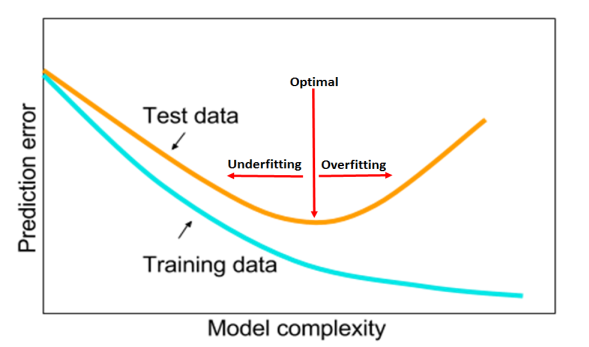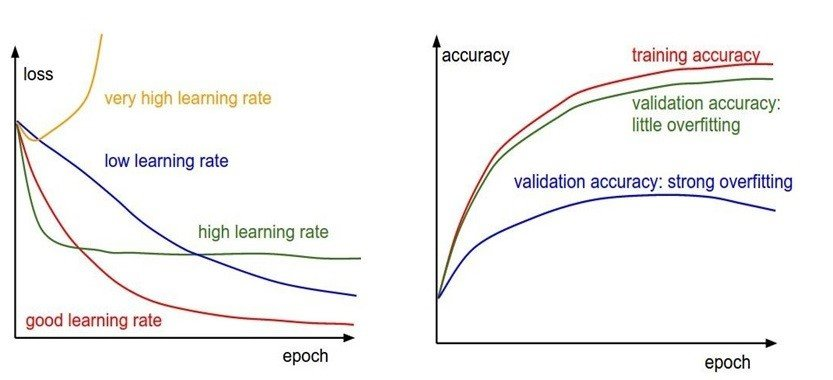

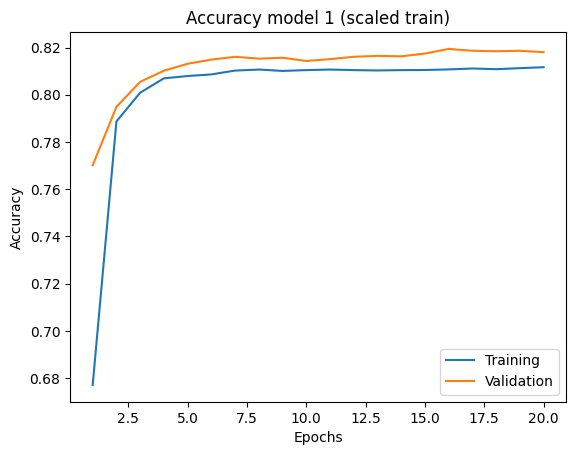

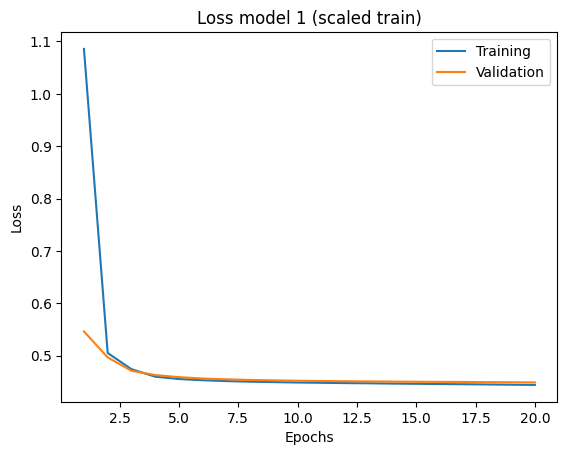

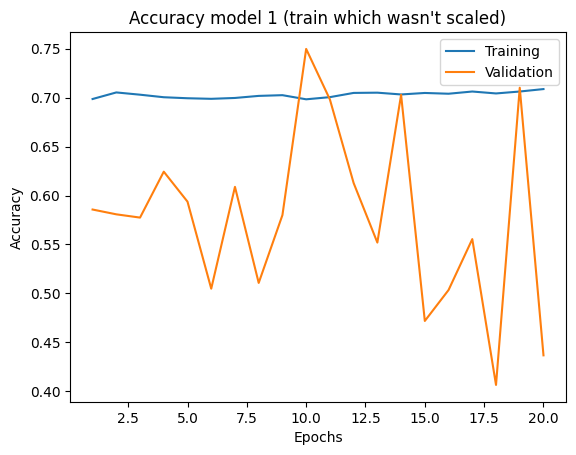

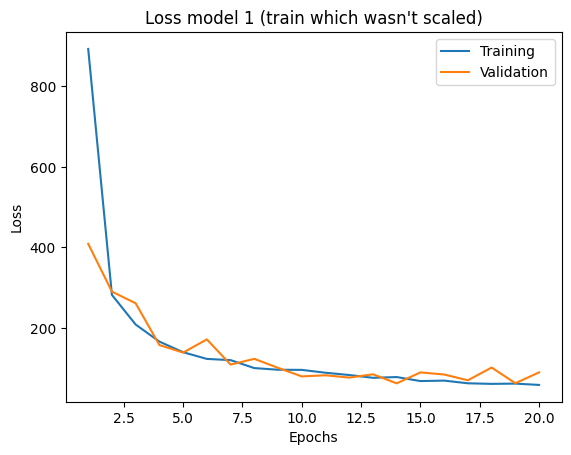

In [189]:
# Model 1
plot_accuracy(history_1_scaled, "Accuracy model 1 (scaled train)")
plot_loss(history_1_scaled, "Loss model 1 (scaled train)")
plot_accuracy(history_1, "Accuracy model 1 (train which wasn't scaled)")
plot_loss(history_1, "Loss model 1 (train which wasn't scaled)")

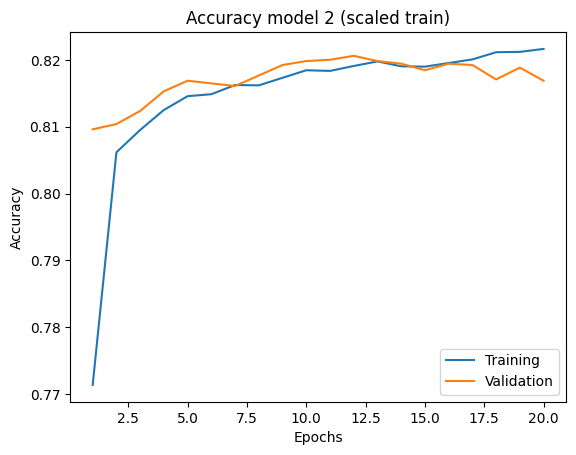

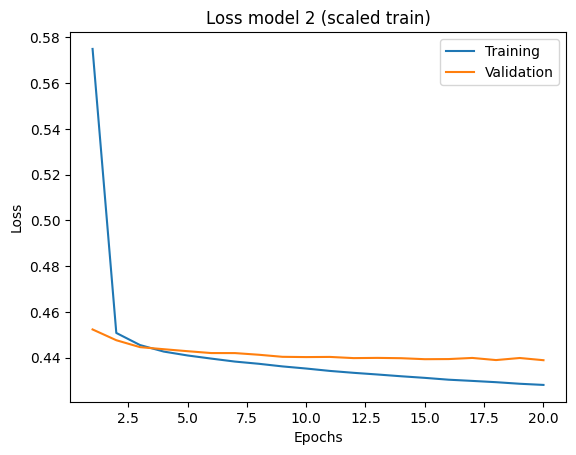

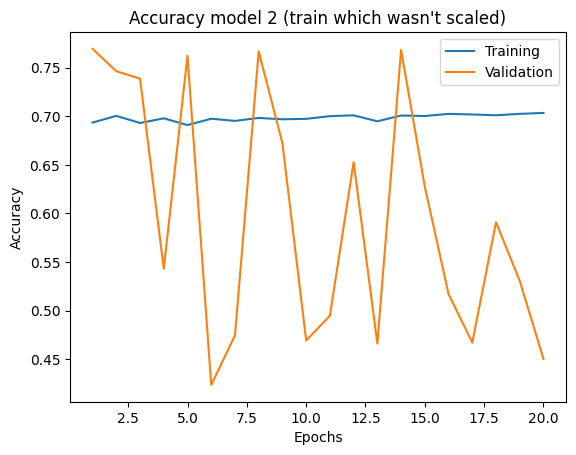

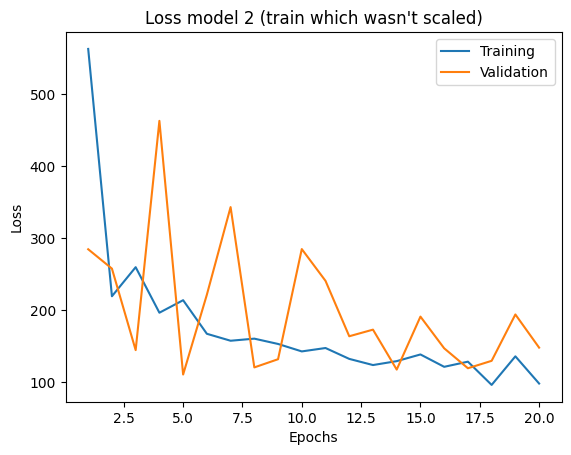

In [190]:
# Model 2
plot_accuracy(history_2_scaled, "Accuracy model 2 (scaled train)")
plot_loss(history_2_scaled, "Loss model 2 (scaled train)")
plot_accuracy(history_2, "Accuracy model 2 (train which wasn't scaled)")
plot_loss(history_2, "Loss model 2 (train which wasn't scaled)")

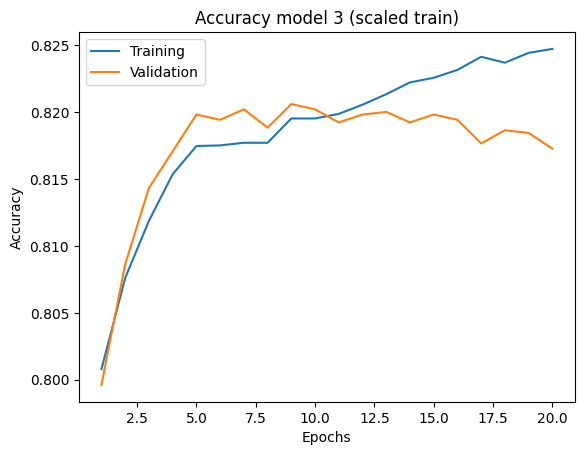

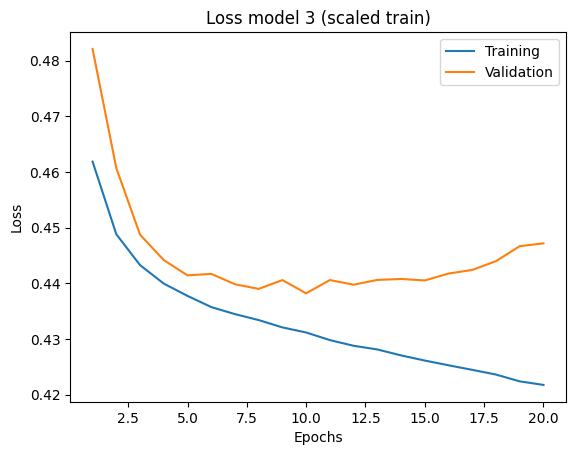

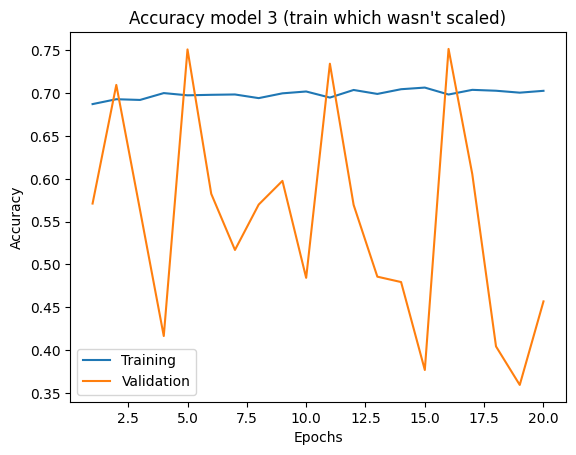

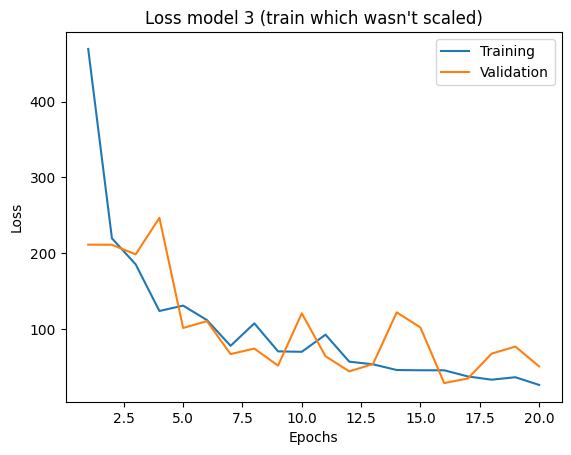

In [191]:
# Model 3
plot_accuracy(history_3_scaled, "Accuracy model 3 (scaled train)")
plot_loss(history_3_scaled, "Loss model 3 (scaled train)")
plot_accuracy(history_3, "Accuracy model 3 (train which wasn't scaled)")
plot_loss(history_3, "Loss model 3 (train which wasn't scaled)")

Here are some considerations for each model:

**Model 1 (scaled train)** \
The training and validation accuracies are stable and close to each other, indicating a balanced model without significant overfitting. The loss curve steadily decreases and plateaus, suggesting good convergence.

**Model 1 (train which wasn't scaled)** \
Validation accuracy fluctuates heavily, showing instability and difficulty in generalizing. This suggests that the lack of scaling makes it harder for the model to learn properly.

**Model 2 (scaled train)** \
Training and validation accuracy curves are close, with only minor fluctuations, indicating a well-balanced model. The loss curve shows a steady decrease, suggesting effective learning without notable overfitting.

**Model 2 (train which wasn't scaled)** \
High fluctuations in validation accuracy and loss suggest instability. The model fails to learn consistently, emphasizing the importance of scaling for stability.

**Model 3 (scaled train)** \
Initially, training and validation curves are close, but after several epochs, training accuracy diverges from validation accuracy, indicating overfitting. The complex model starts to memorize the training data, sacrificing generalization.

**Model 3 (train which wasn't scaled)** \
Extremely volatile validation accuracy and loss show severe instability. The model overfits rapidly and struggles without scaling, demonstrating that scaling is essential, especially for complex models.

We can see scaling is important, we'll try to confirm this in the training metrics.

### Training metrics analysis

In [195]:
# Organize the training results from each model
train_all_results = {
    "Metrics": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Baseline (train)": [
        baseline_train_accuracy,
        baseline_train_precision,
        baseline_train_recall,
        baseline_train_f1_score
    ],
    "Model 1 (scaled train)": [
        model_1_scaled_train_accuracy,
        model_1_scaled_train_precision,
        model_1_scaled_train_recall,
        model_1_scaled_train_f1_score
    ],
    "Model 2 (scaled train)": [
        model_2_scaled_train_accuracy,
        model_2_scaled_train_precision,
        model_2_scaled_train_recall,
        model_2_scaled_train_f1_score
    ],
    "Model 3 (scaled train)": [
        model_3_scaled_train_accuracy,
        model_3_scaled_train_precision,
        model_3_scaled_train_recall,
        model_3_scaled_train_f1_score
    ],
    "Model 1 (train)": [
        model_1_train_accuracy,
        model_1_train_precision,
        model_1_train_recall,
        model_1_train_f1_score
    ],
    "Model 2 (train)": [
        model_2_train_accuracy,
        model_2_train_precision,
        model_2_train_recall,
        model_2_train_f1_score
    ],
    "Model 3 (train)": [
        model_3_train_accuracy,
        model_3_train_precision,
        model_3_train_recall,
        model_3_train_f1_score
    ]
}

train_all_results = pd.DataFrame(train_all_results)

train_all_results

Metrics  Baseline (train)  Model 1 (scaled train)  \
0   Accuracy          0.817586                0.816408   
1  Precision          0.693084                0.654450   
2     Recall          0.326408                0.374120   
3   F1 Score          0.443806                0.476084   

   Model 2 (scaled train)  Model 3 (scaled train)  Model 1 (train)  \
0                0.821511                0.822728         0.450010   
1                0.665498                0.665060         0.250673   
2                0.401056                0.412852         0.737324   
3                0.500494                0.509450         0.374146   

   Model 2 (train)  Model 3 (train)  
0         0.458763         0.465554  
1         0.257999         0.252634  
2         0.760915         0.713380  
3         0.385342         0.373130

The following analysis highlights the difference in accuracy and recall across models, comparing each to the baseline model:

**Baseline Model (train)** \
As seen in a previous section, the baseline has decent accuracy (81.76%) but low recall (32.64%), meaning it misses many positive cases.

**Model 1 (scaled train)** \
Similar accuracy to the baseline (81.64%) but better recall (37.41%), showing that scaling improves the model's ability to detect positive cases. The training is stable, as seen in the learning curves.

**Model 2 (scaled train)** \
Accuracy and recall both improve over the baseline (82.15% accuracy, 40.11% recall), showing that a second layer helps the model capture more patterns without overfitting. 

**Model 3 (scaled train)** \
It shows the best performance with 82.27% accuracy and 41.29% recall, although some **overfitting** starts to appear, as indicated by the separation in the validation curve.

**Model 1 (train)** \
Accuracy drops sharply (45%) while recall is high (73.73%), showing a big imbalance. The unscaled data leads to erratic training with unstable learning curves.

**Model 2 (train)** \
Adding a layer improves recall (76.09%) but accuracy remains low (45.88%), reinforcing that the lack of scaling causes instability and poor generalization.

**Model 3 (train)** \
Accuracy sees minor improvement (46.56%) while recall decreases (71.34%), suggesting that three layers may cause overfitting on unscaled data, as confirmed by erratic validation curves.

\
Overall, scaled models are much more balanced and stable, while unscaled models are unstable and have low accuracy.

## Validate the model and comment the results

Please refer to the previous sections for comments about generalization capability and performance metrics (recall is the most suitable, as said at the beginning too, when showing the target distribution).

## Make predictions (on the provided test set)

From the baseline model we saw the test set may have a similar distribution with respect to the training set, so we could expect similar metrics for the Neural Networks too.

Before checking, we'll need to apply the same preprocessing steps we applied to the training set before.

### Test set preprocessing

In [213]:
# Drop the ID column as it is not relevant
test_data.drop(columns=['ID'], inplace=True)

In [218]:
# Check for missing values
test_data.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

In [219]:
# Check for inconsistencies
get_inconsistency_df(test_data)

Number of Inconsistencies
Feature                             
LIMIT_BAL                          0
SEX                                0
EDUCATION                         59
MARRIAGE                           5
AGE                                0
PAY_0                            446
PAY_2                            583
PAY_3                            631
PAY_4                            689
PAY_5                            721
PAY_6                            750
BILL_AMT1                         88
BILL_AMT2                        113
BILL_AMT3                        109
BILL_AMT4                        127
BILL_AMT5                        110
BILL_AMT6                        115
PAY_AMT1                           0
PAY_AMT2                           0
PAY_AMT3                           0
PAY_AMT4                           0
PAY_AMT5                           0
PAY_AMT6                           0

In [220]:
# Fix the inconsistencies

# EDUCATION: clip to range [1, 4]
test_data['EDUCATION'] = test_data['EDUCATION'].clip(lower=1, upper=4)

# MARRIAGE: clip to range [1, 3]
test_data['MARRIAGE'] = test_data['MARRIAGE'].clip(lower=1, upper=3)

# PAY_0 to PAY_6: clip each to range [-1, 9]
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in pay_columns:
    test_data[col] = test_data[col].clip(lower=-1, upper=9)

# BILL_AMT1 to BILL_AMT6: clip each to minimum 0 (no negative values)
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
for col in bill_columns:
    test_data[col] = test_data[col].clip(lower=0)

In [223]:
# Check for duplicate rows (we won't remove it or the shape won't match)
test_data[test_data.duplicated()]

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
3988     160000    1          2         2   28     -1     -1     -1     -1   

      PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
3988     -1  ...          0          0          0          0         0   

      PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
3988         0         0         0         0         0  

[1 rows x 23 columns]

In [224]:
# Exclude SEX, EDUCATION, MARRIAGE, AGE from test_data
test_data = test_data.drop(columns=['SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])

In [225]:
# Perform log scaling on the features in test_data excluding the specified columns
excluded_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default payment next month']
features_to_scale = [col for col in test_data.columns if col not in excluded_columns]

# Apply log scaling
test_data_scaled = test_data.copy()
test_data_scaled[features_to_scale] = np.log1p(test_data[features_to_scale])

In [227]:
# Scaled test data
test_data_scaled

LIMIT_BAL  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0     12.100718     -1      2     -1      0     -1     -1   7.596894   
1     10.819798      0      0      0     -1      0      0  10.068493   
2     12.388398      1     -1     -1     -1     -1     -1   0.000000   
3     12.100718     -1     -1     -1     -1     -1     -1   7.513709   
4     12.676079      0      0      0      0      0      0  12.237872   
...         ...    ...    ...    ...    ...    ...    ...        ...   
4495  12.345839      0      0      0      0      0      0  11.787150   
4496   9.903538      0      0      0      0      0      0   9.769041   
4497  11.407576      2      2      2      2      2      0  11.385921   
4498  12.206078      2     -1     -1     -1     -1     -1   6.981935   
4499  11.918397      0      0      0      0      0      0  11.326608   

      BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0      6.899723   8.943637   6.908755   7.409136   6.908755  0.000000   
1     10.109729   9.911753   9.281078   9.265491   9.283405  7.496097   
2      8.759512   0.000000   0.000000   0.000000   0.000000  8.759512   
3      0.000000   6.725034   5.808142   6.033086   6.033086  0.000000   
4     11.671373  11.766272  11.800583  10.894348   9.486911  8.517393   
...         ...        ...        ...        ...        ...       ...   
4495  11.791428  11.800222  11.727706  11.731860  11.699994  8.709135   
4496   9.828387   9.875242   9.594173   9.728658   9.245901  7.218177   
4497  11.410029  11.428445  11.422289  10.989589  10.977124  8.412055   
4498   6.546785   5.758902   6.981935   5.758902   7.112327  6.546785   
4499  11.385103  11.440366  11.492733  11.512935   0.000000  8.517393   

      PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
0     8.944811  0.000000  7.409136  6.908755  7.601402  
1     7.482119  9.281078  5.953243  6.630683  6.218600  
2     0.000000  0.000000  0.000000  0.000000  0.000000  
3     6.033086  5.808142  6.216606  8.160804  6.725034  
4     9.615872  8.517393  8.517393  8.006701  8.517393  
...        ...       ...       ...       ...       ...  
4495  8.485909  8.364508  8.322637  8.360539  8.307706  
4496  7.136483  7.072422  5.743003  7.725330  0.000000  
4497  8.294300  7.645398  0.000000  7.639642  7.972811  
4498  5.758902  6.981935  5.758902  7.112327  6.546785  
4499  8.517393  8.517393  7.601402  0.000000  0.000000  

[4500 rows x 19 columns]

In [226]:
# No scaled test data
test_data

LIMIT_BAL  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0        180000     -1      2     -1      0     -1     -1       1991   
1         50000      0      0      0     -1      0      0      23587   
2        240000      1     -1     -1     -1     -1     -1          0   
3        180000     -1     -1     -1     -1     -1     -1       1832   
4        320000      0      0      0      0      0      0     206461   
...         ...    ...    ...    ...    ...    ...    ...        ...   
4495     230000      0      0      0      0      0      0     131550   
4496      20000      0      0      0      0      0      0      17483   
4497      90000      2      2      2      2      2      0      88072   
4498     200000      2     -1     -1     -1     -1     -1       1076   
4499     150000      0      0      0      0      0      0      83000   

      BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0           991       7658       1000       1650       1000         0   
1         24580      20165      10732      10566      10757      1800   
2          6370          0          0          0          0      6370   
3             0        832        332        416        416         0   
4        117168     128832     133329      53870      13185      5000   
...         ...        ...        ...        ...        ...       ...   
4495     132114     133281     123958     124474     120570      6057   
4496      18552      19442      14678      16791      10361      1363   
4497      90221      91898      91334      59253      58519      4500   
4498        696        316       1076        316       1226       696   
4499      88000      93000      98000     100000          0      5000   

      PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
0         7667         0      1650      1000      2000  
1         1775     10732       384       757       501  
2            0         0         0         0         0  
3          416       332       500      3500       832  
4        15000      5000      5000      3000      5000  
...        ...       ...       ...       ...       ...  
4495      4845      4291      4115      4274      4054  
4496      1256      1178       311      2264         0  
4497      4000      2090         0      2078      2900  
4498       316      1076       316      1226       696  
4499      5000      5000      2000         0         0  

[4500 rows x 19 columns]

We can finally make the predictions on the test data, both scaled and not scaled.

### Test set predictions

#### Model 1 - scaled and not scaled

In [240]:
# Model 1 - scaled and not scaled test predictions
y_pred_1_scaled_test = pd.Series((model_1_scaled.predict(test_data_scaled).flatten() > 0.5).astype(int))
y_pred_1_test = pd.Series((model_1.predict(test_data).flatten() > 0.5).astype(int))

# Export in the appropriate format
y_pred_1_scaled_test.to_csv('model_1s_test_predictions.csv', index=False, header=False)
y_pred_1_test.to_csv('model_1_test_predictions.csv', index=False, header=False)

# Show the distribution
print("Model 1 - scaled test")
print(y_pred_1_scaled_test.value_counts())
print("---\nModel 1 - not scaled test")
print(y_pred_1_test.value_counts())

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
Model 1 - scaled test
0    3954
1     546
dtype: int64
---
Model 1 - not scaled test
1    2917
0    1583
dtype: int64


#### Model 2 - scaled and not scaled

In [241]:
# Model 2 - scaled and not scaled test predictions
y_pred_2_scaled_test = pd.Series((model_2_scaled.predict(test_data_scaled).flatten() > 0.5).astype(int))
y_pred_2_test = pd.Series((model_2.predict(test_data).flatten() > 0.5).astype(int))

# Export in the appropriate format
y_pred_2_scaled_test.to_csv('model_2s_test_predictions.csv', index=False, header=False)
y_pred_2_test.to_csv('model_2_test_predictions.csv', index=False, header=False)

# Show the distribution
print("Model 2 - scaled test")
print(y_pred_2_scaled_test.value_counts())
print("---\nModel 2 - not scaled test")
print(y_pred_2_test.value_counts())

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
Model 2 - scaled test
0    3930
1     570
dtype: int64
---
Model 2 - not scaled test
1    2929
0    1571
dtype: int64


#### Model 3 - scaled and not scaled

In [242]:
# Model 3 - scaled and not scaled test predictions
y_pred_3_scaled_test = pd.Series((model_3_scaled.predict(test_data_scaled).flatten() > 0.5).astype(int))
y_pred_3_test = pd.Series((model_3.predict(test_data).flatten() > 0.5).astype(int))

# Export in the appropriate format
y_pred_3_scaled_test.to_csv('model_3s_test_predictions.csv', index=False, header=False)
y_pred_3_test.to_csv('model_3_test_predictions.csv', index=False, header=False)

# Show the distribution
print("Model 3 - scaled test")
print(y_pred_3_scaled_test.value_counts())
print("---\nModel 3 - not scaled test")
print(y_pred_3_test.value_counts())

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
Model 3 - scaled test
0    3911
1     589
dtype: int64
---
Model 3 - not scaled test
1    2779
0    1721
dtype: int64


From the distributions we can confirm that the models using not scaled data don't perform very well, since we saw from the baseline model section that we expect the test data to have ~**3548** rows with the **label 0** and ~**952** rows with the **label 1**. 

We see that models trained without scaling predict too many rows as label 1, compared to the expected 952.

Let's confirm it on the assessment page!

## OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify your prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).

We have already exported everything in the appropriate format, please refer to the previous section.

We will now verify the Neural Networks' predictions on the assessment page and analyze the metrics.

### Model 1 - scaled ("CP_1s")

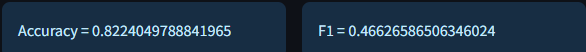

### Model 1 - not scaled ("CP_1")

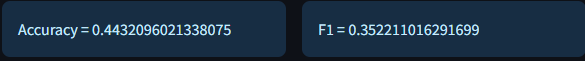

### Model 2 - scaled ("CP_2s")

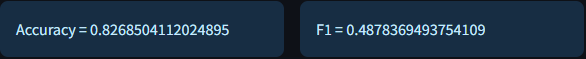

### Model 2 - not scaled ("CP_2")

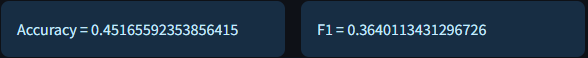

### Model 3 - scaled ("CP_3s")

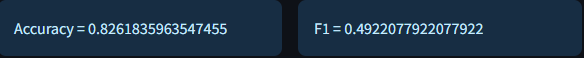

### Model 3 - not scaled ("CP_3")

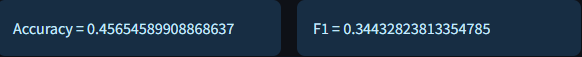

### Final considerations and conclusion

These are the final considerations:

**Model 1 (scaled test)** \
Test accuracy (82.24%) is consistent with training accuracy, and the F1 score (46.63%) is reasonable, indicating the model generalizes well. 
Compared to training metrics, the scaled model achieves a similar balance in test results, confirming stable performance.

**Model 1 (test which wasn't scaled)** \
The test accuracy (44.32%) is low, and the F1 score (35.22%) is significantly below that of the scaled version, which mirrors the unstable training performance seen in learning curves. 
The large gap between training recall (see the previous analysis) and test F1 shows poor generalization, confirming the limitations without scaling.

**Model 2 (scaled test)** \
This model has the highest test accuracy (82.69%) and a strong F1 score (48.78%), showing good generalization and stable performance. 
Training metrics align well with test metrics, demonstrating effective learning.

**Model 2 (test which wasn't scaled)** \
With a low test accuracy (45.17%) and F1 score (36.40%), the unscaled model performs poorly on generalization. 
The lack of stability observed in training continues in the test set, showing that this version fails to capture reliable patterns without scaling.

**Model 3 (scaled test)** \
While Model 3 achieves a high test accuracy (82.62%) and the best F1 score (49.22%) among all models, its complexity and three-layer structure make it prone to **overfitting**, as seen in the training metrics and learning curves. The model captures more positive cases but due to its higher complexity it overfits more easily than less complex models.

**Model 3 (test which wasn't scaled)** \
The test accuracy (45.65%) and F1 score (34.43%) are low, consistent with the poor generalization in unscaled training metrics. 
Adding more layers without scaling makes overfitting worse and reduces test performance.


In conclusion, **Model 2 (scaled)** appears to offer the **best trade-off** between performance and generalization, because
- Model 1 (scaled) generalizes well but lacks the improvements seen in more complex models
- Model 2 (scaled) achieves the highest test accuracy and a strong F1 score without significant overfitting, showing good generalization capabilities
- Model 3 (scaled)'s complex structure leads to overfitting, as seen in the training curves, so it may capture more patterns but it risks memorizing the training data.